In [1]:
from tqdm import tqdm, trange
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import scipy as sp
import time
import sys
import importlib
import os
import hashlib
import subprocess
import gc

from IPython import display
from IPython.display import clear_output
import copy
from copy import deepcopy
from sklearn.metrics import roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

try:
    import cPickle as pickle
except:
    import pickle
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

super_folder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4"
pocket_fit_folder=f"{super_folder}/morphing_annealing_4d09_filtered_subset/"
folder=f"{pocket_fit_folder}/prediction_step_3/"
step_db_file=f"{pocket_fit_folder}/ddG_step_3_sigmahole_scaled_dummy_masses/stable_ligs.pickle"
all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step3_dG.pickle"
all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step3_dG.pickle"

energy_folder="/home/energy/ykhalak/ML_dG/pde2_dG/generators/structures/set_4"
all_ligs_db_file_energy=f"{energy_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step3_dG.pickle"
all_no_core_ligs_db_file_energy=f"{energy_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step3_dG.pickle"

settings_folder=folder+"/combined_repr_search/settings/"
os.makedirs(settings_folder, exist_ok=True)


Bohr2Ang=0.529177249
RT=0.001985875*300 #kcal/mol

import sys
#sys.path.insert(0, folder)
#sys.path.insert(0, f"{pocket_fit_folder}/prediction_step_0/")
sys.path.append(pocket_fit_folder)
#sys.path.append(folder)
sys.path.append(f"{pocket_fit_folder}/prediction_step_0/")

# debug

# Define representation blocks

In [31]:
if 'custom_dataset_modular_with_binning' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning'])
else:
    import custom_dataset_modular_with_binning
from custom_dataset_modular_with_binning import dataBlocks, CustomMolModularDataset

flags_2D=[dataBlocks.MACCS, dataBlocks.Descriptors, dataBlocks.Graph_desc, dataBlocks.BCUT2D]
flags_3D=[dataBlocks.EState_FP, dataBlocks.Pharmacophore_feature_map,
          dataBlocks.MOE, dataBlocks.MQN, dataBlocks.GETAWAY, dataBlocks.AUTOCORR2D,
          dataBlocks.AUTOCORR3D, dataBlocks.WHIM, dataBlocks.RDF,
          dataBlocks.USR, dataBlocks.USRCUT, dataBlocks.PEOE_VSA, dataBlocks.SMR_VSA,
          dataBlocks.SlogP_VSA, dataBlocks.MORSE]

no_core_flags_2D=[dataBlocks.no_core_MACCS, dataBlocks.no_core_Descriptors, dataBlocks.no_core_Graph_desc, dataBlocks.no_core_BCUT2D]
no_core_flags_3D=[dataBlocks.no_core_EState_FP, dataBlocks.no_core_Pharmacophore_feature_map,
          dataBlocks.no_core_MOE, dataBlocks.no_core_MQN,
          # dataBlocks.no_core_GETAWAY, 
          dataBlocks.no_core_AUTOCORR2D,
          dataBlocks.no_core_AUTOCORR3D, dataBlocks.no_core_WHIM, dataBlocks.no_core_RDF,
          #dataBlocks.no_core_USR, dataBlocks.no_core_USRCUT,
          dataBlocks.no_core_PEOE_VSA, dataBlocks.no_core_SMR_VSA,
          dataBlocks.no_core_SlogP_VSA, dataBlocks.no_core_MORSE]

# scan through representations individually (using the 395 step_3 ddG ligs)
and without caching

In [ ]:
# with open(step2_db_file, 'rb') as f:
#     step2_ligs = pickle.load(f)

# Scan through represenatation combinations

### full ligs

In [3]:
normalize_x=True
shuffle_seed=12345678

n_Epochs=20000
#hl_w=300
hl_w=10
hl_depth=2
init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True    
use_dropout=True
#shiftY=False
shiftY=True

redo=False

block_names_full=["2D_3D", "PLEC_filtered", "MDenerg", "atom_hot"]
import itertools
l = [False, True]
combs=list(itertools.product(l, repeat=len(block_names_full)))
print(len(combs))
#raise()

for c in combs:
    b_2D_3D, b_PLEC_filt, b_MDenerg, b_ah = c
    
    representation_flags=[0]*len(dataBlocks)
    ntot_repr=0
    
    if(b_2D_3D):
        for b in flags_2D:
            representation_flags[int(b)]=1
        for b in flags_3D:
            representation_flags[int(b)]=1
        ntot_repr+=1
    if(b_PLEC_filt):
        representation_flags[int(dataBlocks.PLEC_filtered)]=1
        ntot_repr+=1
    if(b_MDenerg):
        representation_flags[int(dataBlocks.MDenerg)]=1
        ntot_repr+=1
    if(b_ah):
        representation_flags[int(dataBlocks.atom_hot)]=1
        ntot_repr+=1
        
    if(ntot_repr<=1):
        continue
    

    dr_name=""
    for i in range(len(c)):
        if c[i]:
            dr_name+=block_names_full[i]+'_'
    dr_name=dr_name[:-1]
    
    settings=[
        representation_flags, dr_name, normalize_x, shuffle_seed,
        n_Epochs, hl_w, hl_depth, init_learning_rate, learning_rate_decay, weight_decay,
        impfilt, X_filter,
        weighted, shiftY, use_dropout
        ]
    
    
    sha = hashlib.sha256()
    sha.update(pickle.dumps(settings))
    settings_hash=dr_name+"_"+sha.hexdigest()[:10]

    settings_fname=settings_folder+f"{settings_hash}.pickle"
    if(os.path.exists(settings_fname)):
        with open(settings_fname, 'rb') as f:
            settings_loaded, metrics = pickle.load(f)
            if(metrics is not None and not redo):
                print(f"{settings_fname} is already trained.")
            else:
                print(f"{settings_fname} exists but is not trained yet.")
    else:
        pickle.dump( (settings, None), open( settings_fname, "wb" ) )

16


### R-Groups

In [5]:
normalize_x=True
shuffle_seed=12345678

n_Epochs=20000
#hl_w=300
hl_w=10
hl_depth=2
init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True    
use_dropout=True
#shiftY=False
shiftY=True

redo=False

block_names_no_core=["no_core_2D_3D", "no_core_PLEC_filtered", "no_core_MDenerg", "no_core_atom_hot"]
import itertools
l = [False, True]
combs=list(itertools.product(l, repeat=len(block_names_no_core)))
print(len(combs))
#raise()

for c in combs:
    b_2D_3D, b_PLEC_filt, b_MDenerg, b_ah = c
    if np.count_nonzero(c)==0:
        continue # skip the case with no active reperesenations
        
    representation_flags=[0]*len(dataBlocks)
    
    ntot_repr=0
    
    if(b_2D_3D):
        for b in no_core_flags_2D:
            representation_flags[int(b)]=1
        for b in no_core_flags_3D:
            representation_flags[int(b)]=1
        ntot_repr+=1
    if(b_PLEC_filt):
        representation_flags[int(dataBlocks.no_core_PLEC_filtered)]=1
        ntot_repr+=1
    if(b_MDenerg):
        representation_flags[int(dataBlocks.no_core_MDenerg)]=1
        ntot_repr+=1
    if(b_ah):
        representation_flags[int(dataBlocks.no_core_atom_hot)]=1
        ntot_repr+=1

    if(ntot_repr<=1):
        continue

    dr_name=""
    for i in range(len(c)):
        if c[i]:
            dr_name+=block_names_no_core[i]+'_'
    dr_name=dr_name[:-1]
    
    settings=[
        representation_flags, dr_name, normalize_x, shuffle_seed,
        n_Epochs, hl_w, hl_depth, init_learning_rate, learning_rate_decay, weight_decay,
        impfilt, X_filter,
        weighted, shiftY, use_dropout
        ]
    
    
    sha = hashlib.sha256()
    sha.update(pickle.dumps(settings))
    settings_hash=dr_name+"_"+sha.hexdigest()[:10]

    settings_fname=settings_folder+f"{settings_hash}.pickle"
    if(os.path.exists(settings_fname)):
        with open(settings_fname, 'rb') as f:
            settings_loaded, metrics = pickle.load(f)
            if(metrics is not None and not redo):
                print(f"{settings_fname} is already trained.")
            else:
                print(f"{settings_fname} exists but is not trained yet.")
    else:
        pickle.dump( (settings, None), open( settings_fname, "wb" ) )

16


# import training script

In [32]:
if 'owl_trainer_w_params_general' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_general'])
else:
    import owl_trainer_w_params_general
from owl_trainer_w_params_general import *

# Run locally

100%|██████████| 22/22 [00:01<00:00, 20.77it/s]

previously_done: 21 	 out of: 22


settings left: 1 	 # workers: 1 	 # settings/worker: 1




Representation is: no_core_2D_3D_no_core_PLEC_filtered_no_core_MDenerg_no_core_atom_hot
# of training ligands found: 395 2022-02-03 10:28:16.688292
# starting ligands: 395 2022-02-03 10:28:16.876685
Finished setting up weights 2022-02-03 10:28:17.262533
Building the internal_filtered_cache needs 3329.3631591796875 MB, more than the 512.0 MB limit. SKIPPING and will read samples from HDD each time instead.
Found normalization factors across all ligands 2022-02-03 10:28:31.648179
Start setting up models 2022-02-03 10:28:31.667825
Finished setup for model 0 2022-02-03 10:31:29.572495
Finished setup for model 1 2022-02-03 10:31:29.861719
Finished setup for model 2 2022-02-03 10:31:30.138432
Finished setup for model 3 2022-02-03 10:31:30.415479
Finished setup for model 4 2022-02-03 10:31:30.690929
Training for 20000 epochs 2022-02-03 10:31:30.691228
	Epoch: 0	 train_loss=3.9248820304870606	 XVal_RMSE=5.800841331481934
	Epoch: 9	 tra

	Epoch: 999	 train_loss=0.14792841970920562	 XVal_RMSE=2.127960443496704
Epoch 999. Backing up models.
	Epoch: 1009	 train_loss=0.12307571470737458	 XVal_RMSE=2.1534478664398193
	Epoch: 1019	 train_loss=0.11549172550439835	 XVal_RMSE=2.14807391166687
	Epoch: 1029	 train_loss=0.11060446053743363	 XVal_RMSE=2.1492671966552734
	Epoch: 1039	 train_loss=0.11447741612792015	 XVal_RMSE=2.145087957382202
	Epoch: 1049	 train_loss=0.1355008825659752	 XVal_RMSE=2.1444690227508545
	Epoch: 1059	 train_loss=0.14186436384916307	 XVal_RMSE=2.133735179901123
	Epoch: 1069	 train_loss=0.14165752828121186	 XVal_RMSE=2.131649971008301
	Epoch: 1079	 train_loss=0.1252101592719555	 XVal_RMSE=2.155970573425293
	Epoch: 1089	 train_loss=0.13403671532869338	 XVal_RMSE=2.137226104736328
	Epoch: 1099	 train_loss=0.10937777608633041	 XVal_RMSE=2.1337640285491943
	Epoch: 1109	 train_loss=0.12383506298065186	 XVal_RMSE=2.122013807296753
	Epoch: 1119	 train_loss=0.1334066189825535	 XVal_RMSE=2.1460139751434326
	Epoch: 

	Epoch: 2099	 train_loss=0.10550464540719987	 XVal_RMSE=2.0496060848236084
	Epoch: 2109	 train_loss=0.1005920186638832	 XVal_RMSE=2.0427937507629395
	Epoch: 2119	 train_loss=0.09274547696113586	 XVal_RMSE=2.0503292083740234
	Epoch: 2129	 train_loss=0.10414877757430077	 XVal_RMSE=2.056462526321411
	Epoch: 2139	 train_loss=0.11061780378222466	 XVal_RMSE=2.045957565307617
	Epoch: 2149	 train_loss=0.11117941439151764	 XVal_RMSE=2.050865888595581
	Epoch: 2159	 train_loss=0.10957698300480842	 XVal_RMSE=2.036206007003784
	Epoch: 2169	 train_loss=0.10684188008308411	 XVal_RMSE=2.0550334453582764
	Epoch: 2179	 train_loss=0.10488433688879013	 XVal_RMSE=2.0485076904296875
	Epoch: 2189	 train_loss=0.09535879120230675	 XVal_RMSE=2.0486435890197754
	Epoch: 2199	 train_loss=0.08463976755738259	 XVal_RMSE=2.0470995903015137
	Epoch: 2209	 train_loss=0.09991780892014504	 XVal_RMSE=2.043262481689453
	Epoch: 2219	 train_loss=0.08727299049496651	 XVal_RMSE=2.0450706481933594
	Epoch: 2229	 train_loss=0.0932

	Epoch: 3199	 train_loss=0.07394438683986664	 XVal_RMSE=1.9959490299224854
	Epoch: 3209	 train_loss=0.08083344474434853	 XVal_RMSE=2.0008769035339355
	Epoch: 3219	 train_loss=0.07890808060765267	 XVal_RMSE=1.9961072206497192
	Epoch: 3229	 train_loss=0.07714659348130226	 XVal_RMSE=1.9994884729385376
	Epoch: 3239	 train_loss=0.08194969221949577	 XVal_RMSE=1.9983153343200684
	Epoch: 3249	 train_loss=0.07362470328807831	 XVal_RMSE=1.9922432899475098
	Epoch: 3259	 train_loss=0.08263297453522682	 XVal_RMSE=1.9885830879211426
	Epoch: 3269	 train_loss=0.07848631069064141	 XVal_RMSE=1.9958324432373047
	Epoch: 3279	 train_loss=0.07837277427315711	 XVal_RMSE=1.9882298707962036
	Epoch: 3289	 train_loss=0.08935745954513549	 XVal_RMSE=2.003537893295288
	Epoch: 3299	 train_loss=0.07476260922849179	 XVal_RMSE=1.9872709512710571
	Epoch: 3309	 train_loss=0.08405455946922302	 XVal_RMSE=1.9900873899459839
	Epoch: 3319	 train_loss=0.07832628302276134	 XVal_RMSE=1.987960934638977
	Epoch: 3329	 train_loss=0.

	Epoch: 4299	 train_loss=0.0643692746758461	 XVal_RMSE=1.9596304893493652
	Epoch: 4309	 train_loss=0.06266225501894951	 XVal_RMSE=1.9635207653045654
	Epoch: 4319	 train_loss=0.07001188397407532	 XVal_RMSE=1.9617401361465454
	Epoch: 4329	 train_loss=0.07100234404206276	 XVal_RMSE=1.955208659172058
	Epoch: 4339	 train_loss=0.06806403286755085	 XVal_RMSE=1.963284969329834
	Epoch: 4349	 train_loss=0.062255749478936195	 XVal_RMSE=1.9591392278671265
	Epoch: 4359	 train_loss=0.0629297573119402	 XVal_RMSE=1.9593751430511475
	Epoch: 4369	 train_loss=0.06203670129179954	 XVal_RMSE=1.9579147100448608
	Epoch: 4379	 train_loss=0.06440303698182107	 XVal_RMSE=1.9611139297485352
	Epoch: 4389	 train_loss=0.06886484920978546	 XVal_RMSE=1.954980731010437
	Epoch: 4399	 train_loss=0.07137656174600124	 XVal_RMSE=1.957118272781372
	Epoch: 4409	 train_loss=0.07408704608678818	 XVal_RMSE=1.95662260055542
	Epoch: 4419	 train_loss=0.06721094697713852	 XVal_RMSE=1.9610997438430786
	Epoch: 4429	 train_loss=0.06673

	Epoch: 5399	 train_loss=0.05765157975256443	 XVal_RMSE=1.9347732067108154
	Epoch: 5409	 train_loss=0.057220163941383365	 XVal_RMSE=1.9388824701309204
	Epoch: 5419	 train_loss=0.053075652569532394	 XVal_RMSE=1.9349466562271118
	Epoch: 5429	 train_loss=0.05511181950569153	 XVal_RMSE=1.9337531328201294
	Epoch: 5439	 train_loss=0.05434996485710144	 XVal_RMSE=1.9366849660873413
	Epoch: 5449	 train_loss=0.052907423675060274	 XVal_RMSE=1.9365630149841309
	Epoch: 5459	 train_loss=0.056581874191761014	 XVal_RMSE=1.9352319240570068
	Epoch: 5469	 train_loss=0.05644531734287739	 XVal_RMSE=1.9334343671798706
	Epoch: 5479	 train_loss=0.056326210498809814	 XVal_RMSE=1.9382801055908203
	Epoch: 5489	 train_loss=0.053306497633457184	 XVal_RMSE=1.9370253086090088
	Epoch: 5499	 train_loss=0.05147786810994148	 XVal_RMSE=1.93553626537323
	Epoch: 5509	 train_loss=0.05285555832087994	 XVal_RMSE=1.93680739402771
	Epoch: 5519	 train_loss=0.05529911443591118	 XVal_RMSE=1.935697317123413
	Epoch: 5529	 train_loss

	Epoch: 6489	 train_loss=0.049308999255299565	 XVal_RMSE=1.9215446710586548
	Epoch: 6499	 train_loss=0.04830854050815105	 XVal_RMSE=1.9229618310928345
	Epoch: 6509	 train_loss=0.0487841684371233	 XVal_RMSE=1.921207308769226
	Epoch: 6519	 train_loss=0.05101198926568031	 XVal_RMSE=1.923282504081726
	Epoch: 6529	 train_loss=0.04928426332771778	 XVal_RMSE=1.9212353229522705
	Epoch: 6539	 train_loss=0.051371827349066736	 XVal_RMSE=1.9251012802124023
	Epoch: 6549	 train_loss=0.05605352632701397	 XVal_RMSE=1.9201042652130127
	Epoch: 6559	 train_loss=0.052832144871354104	 XVal_RMSE=1.9243286848068237
	Epoch: 6569	 train_loss=0.04996390789747238	 XVal_RMSE=1.9224427938461304
	Epoch: 6579	 train_loss=0.058136153221130374	 XVal_RMSE=1.9251972436904907
	Epoch: 6589	 train_loss=0.05942350663244724	 XVal_RMSE=1.924046516418457
	Epoch: 6599	 train_loss=0.05243507958948612	 XVal_RMSE=1.9220588207244873
	Epoch: 6609	 train_loss=0.05276487357914448	 XVal_RMSE=1.918773889541626
	Epoch: 6619	 train_loss=0

	Epoch: 7579	 train_loss=0.04807736240327358	 XVal_RMSE=1.9132403135299683
	Epoch: 7589	 train_loss=0.04910396970808506	 XVal_RMSE=1.910311222076416
	Epoch: 7599	 train_loss=0.046761858835816385	 XVal_RMSE=1.9130539894104004
	Epoch: 7609	 train_loss=0.04548921212553978	 XVal_RMSE=1.9141209125518799
	Epoch: 7619	 train_loss=0.04634049944579601	 XVal_RMSE=1.9101399183273315
	Epoch: 7629	 train_loss=0.04519788697361946	 XVal_RMSE=1.913386344909668
	Epoch: 7639	 train_loss=0.04357274416834116	 XVal_RMSE=1.9119749069213867
	Epoch: 7649	 train_loss=0.04563842788338661	 XVal_RMSE=1.9131364822387695
	Epoch: 7659	 train_loss=0.04482909198850393	 XVal_RMSE=1.9134550094604492
	Epoch: 7669	 train_loss=0.04980836994946003	 XVal_RMSE=1.913707971572876
	Epoch: 7679	 train_loss=0.047710057348012924	 XVal_RMSE=1.9111099243164062
	Epoch: 7689	 train_loss=0.04718043208122254	 XVal_RMSE=1.9115667343139648
	Epoch: 7699	 train_loss=0.04669835418462753	 XVal_RMSE=1.9130836725234985
	Epoch: 7709	 train_loss=0

	Epoch: 8669	 train_loss=0.041848585568368436	 XVal_RMSE=1.906465768814087
	Epoch: 8679	 train_loss=0.04414302632212639	 XVal_RMSE=1.9062914848327637
	Epoch: 8689	 train_loss=0.044849804043769835	 XVal_RMSE=1.907173991203308
	Epoch: 8699	 train_loss=0.042798425629734994	 XVal_RMSE=1.9062998294830322
	Epoch: 8709	 train_loss=0.04282177463173866	 XVal_RMSE=1.9071763753890991
	Epoch: 8719	 train_loss=0.04309141710400581	 XVal_RMSE=1.905739426612854
	Epoch: 8729	 train_loss=0.043552912399172784	 XVal_RMSE=1.9054228067398071
	Epoch: 8739	 train_loss=0.04321203120052815	 XVal_RMSE=1.9051088094711304
	Epoch: 8749	 train_loss=0.04237321726977825	 XVal_RMSE=1.9068909883499146
	Epoch: 8759	 train_loss=0.04354439452290535	 XVal_RMSE=1.9039158821105957
	Epoch: 8769	 train_loss=0.042820383608341214	 XVal_RMSE=1.9048473834991455
	Epoch: 8779	 train_loss=0.04549170434474945	 XVal_RMSE=1.904043197631836
	Epoch: 8789	 train_loss=0.044275331497192386	 XVal_RMSE=1.905484914779663
	Epoch: 8799	 train_loss

	Epoch: 9759	 train_loss=0.04275896567851305	 XVal_RMSE=1.9011470079421997
	Epoch: 9769	 train_loss=0.03995874505490064	 XVal_RMSE=1.9022514820098877
	Epoch: 9779	 train_loss=0.03986230231821537	 XVal_RMSE=1.9004789590835571
	Epoch: 9789	 train_loss=0.040501823835074904	 XVal_RMSE=1.9007662534713745
	Epoch: 9799	 train_loss=0.042558330483734606	 XVal_RMSE=1.9013309478759766
	Epoch: 9809	 train_loss=0.04100436381995678	 XVal_RMSE=1.8993357419967651
	Epoch: 9819	 train_loss=0.04250668808817863	 XVal_RMSE=1.902121901512146
	Epoch: 9829	 train_loss=0.04188112281262875	 XVal_RMSE=1.9005160331726074
	Epoch: 9839	 train_loss=0.040570710226893424	 XVal_RMSE=1.9001741409301758
	Epoch: 9849	 train_loss=0.0405027674511075	 XVal_RMSE=1.9012690782546997
	Epoch: 9859	 train_loss=0.041620833426713945	 XVal_RMSE=1.900639533996582
	Epoch: 9869	 train_loss=0.0406631039455533	 XVal_RMSE=1.9013314247131348
	Epoch: 9879	 train_loss=0.04285911060869694	 XVal_RMSE=1.89983069896698
	Epoch: 9889	 train_loss=0.

	Epoch: 10839	 train_loss=0.038423397950828074	 XVal_RMSE=1.8973475694656372
	Epoch: 10849	 train_loss=0.03984712399542332	 XVal_RMSE=1.8973771333694458
	Epoch: 10859	 train_loss=0.03864042917266488	 XVal_RMSE=1.8977175951004028
	Epoch: 10869	 train_loss=0.04138223584741354	 XVal_RMSE=1.8968013525009155
	Epoch: 10879	 train_loss=0.03926269803196192	 XVal_RMSE=1.898571491241455
	Epoch: 10889	 train_loss=0.03951000291854143	 XVal_RMSE=1.8973115682601929
	Epoch: 10899	 train_loss=0.03769235489889979	 XVal_RMSE=1.8977051973342896
	Epoch: 10909	 train_loss=0.03989266287535429	 XVal_RMSE=1.8983060121536255
	Epoch: 10919	 train_loss=0.03849300760775805	 XVal_RMSE=1.8973804712295532
	Epoch: 10929	 train_loss=0.038296311907470224	 XVal_RMSE=1.8971469402313232
	Epoch: 10939	 train_loss=0.040144804678857324	 XVal_RMSE=1.8979010581970215
	Epoch: 10949	 train_loss=0.039987787045538424	 XVal_RMSE=1.8972243070602417
	Epoch: 10959	 train_loss=0.04026689250022173	 XVal_RMSE=1.8965141773223877
	Epoch: 1

	Epoch: 11919	 train_loss=0.03662691041827202	 XVal_RMSE=1.8954722881317139
	Epoch: 11929	 train_loss=0.037121813744306564	 XVal_RMSE=1.895003080368042
	Epoch: 11939	 train_loss=0.0380326971411705	 XVal_RMSE=1.8954846858978271
	Epoch: 11949	 train_loss=0.03702715989202261	 XVal_RMSE=1.8943814039230347
	Epoch: 11959	 train_loss=0.03820153884589672	 XVal_RMSE=1.8949260711669922
	Epoch: 11969	 train_loss=0.03704327316954732	 XVal_RMSE=1.8948071002960205
	Epoch: 11979	 train_loss=0.039227680675685404	 XVal_RMSE=1.8957175016403198
	Epoch: 11989	 train_loss=0.03911863174289465	 XVal_RMSE=1.895493507385254
	Epoch: 11999	 train_loss=0.038160255178809166	 XVal_RMSE=1.8954062461853027
Epoch 11999. Backing up models.
	Epoch: 12009	 train_loss=0.03858358506113291	 XVal_RMSE=1.895545244216919
	Epoch: 12019	 train_loss=0.03783483151346445	 XVal_RMSE=1.8950427770614624
	Epoch: 12029	 train_loss=0.03769000843167305	 XVal_RMSE=1.8947560787200928
	Epoch: 12039	 train_loss=0.03844796847552061	 XVal_RMSE=

	Epoch: 12999	 train_loss=0.03697277558967471	 XVal_RMSE=1.8931825160980225
Epoch 12999. Backing up models.
	Epoch: 13009	 train_loss=0.03782143387943506	 XVal_RMSE=1.8926894664764404
	Epoch: 13019	 train_loss=0.036727173067629335	 XVal_RMSE=1.8932507038116455
	Epoch: 13029	 train_loss=0.03883908446878195	 XVal_RMSE=1.8932167291641235
	Epoch: 13039	 train_loss=0.0376330778002739	 XVal_RMSE=1.8935139179229736
	Epoch: 13049	 train_loss=0.0374117024242878	 XVal_RMSE=1.8932640552520752
	Epoch: 13059	 train_loss=0.0375368176959455	 XVal_RMSE=1.8928806781768799
	Epoch: 13069	 train_loss=0.03790260050445795	 XVal_RMSE=1.8928991556167603
	Epoch: 13079	 train_loss=0.036551558040082456	 XVal_RMSE=1.892899990081787
	Epoch: 13089	 train_loss=0.037559626437723634	 XVal_RMSE=1.8933429718017578
	Epoch: 13099	 train_loss=0.03799132313579321	 XVal_RMSE=1.8930140733718872
	Epoch: 13109	 train_loss=0.03681548498570919	 XVal_RMSE=1.893135666847229
	Epoch: 13119	 train_loss=0.03611976495012641	 XVal_RMSE=1

	Epoch: 14069	 train_loss=0.03598755430430174	 XVal_RMSE=1.8921741247177124
	Epoch: 14079	 train_loss=0.03583477828651667	 XVal_RMSE=1.8924946784973145
	Epoch: 14089	 train_loss=0.036278306134045125	 XVal_RMSE=1.891567587852478
	Epoch: 14099	 train_loss=0.035953186079859735	 XVal_RMSE=1.8920111656188965
	Epoch: 14109	 train_loss=0.03593606883659959	 XVal_RMSE=1.8920247554779053
	Epoch: 14119	 train_loss=0.03607505867257714	 XVal_RMSE=1.8920735120773315
	Epoch: 14129	 train_loss=0.03600715696811676	 XVal_RMSE=1.8920936584472656
	Epoch: 14139	 train_loss=0.03617250565439463	 XVal_RMSE=1.8917502164840698
	Epoch: 14149	 train_loss=0.03562148101627827	 XVal_RMSE=1.8924129009246826
	Epoch: 14159	 train_loss=0.03587426049634814	 XVal_RMSE=1.8921018838882446
	Epoch: 14169	 train_loss=0.0355727911926806	 XVal_RMSE=1.8923701047897339
	Epoch: 14179	 train_loss=0.0357413406483829	 XVal_RMSE=1.892095685005188
	Epoch: 14189	 train_loss=0.035643068980425595	 XVal_RMSE=1.892506718635559
	Epoch: 14199	

	Epoch: 15149	 train_loss=0.03527924064546824	 XVal_RMSE=1.8912627696990967
	Epoch: 15159	 train_loss=0.03470474136993289	 XVal_RMSE=1.8915830850601196
	Epoch: 15169	 train_loss=0.03576988484710455	 XVal_RMSE=1.8914660215377808
	Epoch: 15179	 train_loss=0.034887386672198775	 XVal_RMSE=1.8911672830581665
	Epoch: 15189	 train_loss=0.03540605753660202	 XVal_RMSE=1.8909835815429688
	Epoch: 15199	 train_loss=0.03525622067973018	 XVal_RMSE=1.8909188508987427
	Epoch: 15209	 train_loss=0.03514172276481986	 XVal_RMSE=1.8914254903793335
	Epoch: 15219	 train_loss=0.03502284539863467	 XVal_RMSE=1.8912328481674194
	Epoch: 15229	 train_loss=0.03511398835107684	 XVal_RMSE=1.8913381099700928
	Epoch: 15239	 train_loss=0.035514038428664206	 XVal_RMSE=1.8908663988113403
	Epoch: 15249	 train_loss=0.03502579424530268	 XVal_RMSE=1.8915337324142456
	Epoch: 15259	 train_loss=0.034740247577428815	 XVal_RMSE=1.8911007642745972
	Epoch: 15269	 train_loss=0.03491325573995709	 XVal_RMSE=1.8912888765335083
	Epoch: 1

	Epoch: 16229	 train_loss=0.03461214350536466	 XVal_RMSE=1.8908203840255737
	Epoch: 16239	 train_loss=0.03474665181711316	 XVal_RMSE=1.8902579545974731
	Epoch: 16249	 train_loss=0.03490333901718259	 XVal_RMSE=1.8908556699752808
	Epoch: 16259	 train_loss=0.035108241438865664	 XVal_RMSE=1.89010751247406
	Epoch: 16269	 train_loss=0.034990917146205905	 XVal_RMSE=1.8908710479736328
	Epoch: 16279	 train_loss=0.03496230477467179	 XVal_RMSE=1.890649676322937
	Epoch: 16289	 train_loss=0.03453251477330923	 XVal_RMSE=1.8905457258224487
	Epoch: 16299	 train_loss=0.03438835982233286	 XVal_RMSE=1.890529990196228
	Epoch: 16309	 train_loss=0.034761955589056016	 XVal_RMSE=1.8908904790878296
	Epoch: 16319	 train_loss=0.03480343846604228	 XVal_RMSE=1.890445590019226
	Epoch: 16329	 train_loss=0.03462797412648797	 XVal_RMSE=1.8906376361846924
	Epoch: 16339	 train_loss=0.03465469032526016	 XVal_RMSE=1.8902679681777954
	Epoch: 16349	 train_loss=0.03442971603944898	 XVal_RMSE=1.8906224966049194
	Epoch: 16359	

	Epoch: 17309	 train_loss=0.03421283401548862	 XVal_RMSE=1.890312910079956
	Epoch: 17319	 train_loss=0.03423789981752634	 XVal_RMSE=1.8902359008789062
	Epoch: 17329	 train_loss=0.03447525324299931	 XVal_RMSE=1.8901728391647339
	Epoch: 17339	 train_loss=0.03534655058756471	 XVal_RMSE=1.8898341655731201
	Epoch: 17349	 train_loss=0.03499973705038428	 XVal_RMSE=1.8897452354431152
	Epoch: 17359	 train_loss=0.03445873679593205	 XVal_RMSE=1.8900192975997925
	Epoch: 17369	 train_loss=0.03428884958848357	 XVal_RMSE=1.8898309469223022
	Epoch: 17379	 train_loss=0.03447854528203607	 XVal_RMSE=1.890051245689392
	Epoch: 17389	 train_loss=0.034175148047506806	 XVal_RMSE=1.8902467489242554
	Epoch: 17399	 train_loss=0.03426822712644935	 XVal_RMSE=1.8899723291397095
	Epoch: 17409	 train_loss=0.03408140130341053	 XVal_RMSE=1.890133261680603
	Epoch: 17419	 train_loss=0.033990345895290375	 XVal_RMSE=1.8903001546859741
	Epoch: 17429	 train_loss=0.034044725727289914	 XVal_RMSE=1.8901859521865845
	Epoch: 1743

	Epoch: 18389	 train_loss=0.03373589720577001	 XVal_RMSE=1.8897509574890137
	Epoch: 18399	 train_loss=0.03393894312903285	 XVal_RMSE=1.8897279500961304
	Epoch: 18409	 train_loss=0.034037396870553495	 XVal_RMSE=1.889839768409729
	Epoch: 18419	 train_loss=0.033866782858967784	 XVal_RMSE=1.8898303508758545
	Epoch: 18429	 train_loss=0.03399395272135734	 XVal_RMSE=1.8896193504333496
	Epoch: 18439	 train_loss=0.033871654979884626	 XVal_RMSE=1.889811396598816
	Epoch: 18449	 train_loss=0.03410157589241862	 XVal_RMSE=1.8897380828857422
	Epoch: 18459	 train_loss=0.03383801905438304	 XVal_RMSE=1.8897253274917603
	Epoch: 18469	 train_loss=0.03382922504097223	 XVal_RMSE=1.8897619247436523
	Epoch: 18479	 train_loss=0.03393673012033105	 XVal_RMSE=1.8898686170578003
	Epoch: 18489	 train_loss=0.033965821005404	 XVal_RMSE=1.8894461393356323
	Epoch: 18499	 train_loss=0.03361259046941996	 XVal_RMSE=1.889824390411377
	Epoch: 18509	 train_loss=0.03376950118690729	 XVal_RMSE=1.889711618423462
	Epoch: 18519	 

	Epoch: 19469	 train_loss=0.03382227048277855	 XVal_RMSE=1.8894894123077393
	Epoch: 19479	 train_loss=0.0336834785528481	 XVal_RMSE=1.889411449432373
	Epoch: 19489	 train_loss=0.03350172322243452	 XVal_RMSE=1.889471173286438
	Epoch: 19499	 train_loss=0.033447110652923585	 XVal_RMSE=1.8894983530044556
	Epoch: 19509	 train_loss=0.03344087777659297	 XVal_RMSE=1.889536738395691
	Epoch: 19519	 train_loss=0.03351587252691388	 XVal_RMSE=1.8894895315170288
	Epoch: 19529	 train_loss=0.0336517701856792	 XVal_RMSE=1.8894771337509155
	Epoch: 19539	 train_loss=0.03362656272947788	 XVal_RMSE=1.8895999193191528
	Epoch: 19549	 train_loss=0.03359265439212322	 XVal_RMSE=1.8894554376602173
	Epoch: 19559	 train_loss=0.033683966379612684	 XVal_RMSE=1.8895057439804077
	Epoch: 19569	 train_loss=0.03378050196915865	 XVal_RMSE=1.889376163482666
	Epoch: 19579	 train_loss=0.03369209673255682	 XVal_RMSE=1.8894199132919312
	Epoch: 19589	 train_loss=0.033839387632906434	 XVal_RMSE=1.889517068862915
	Epoch: 19599	 t

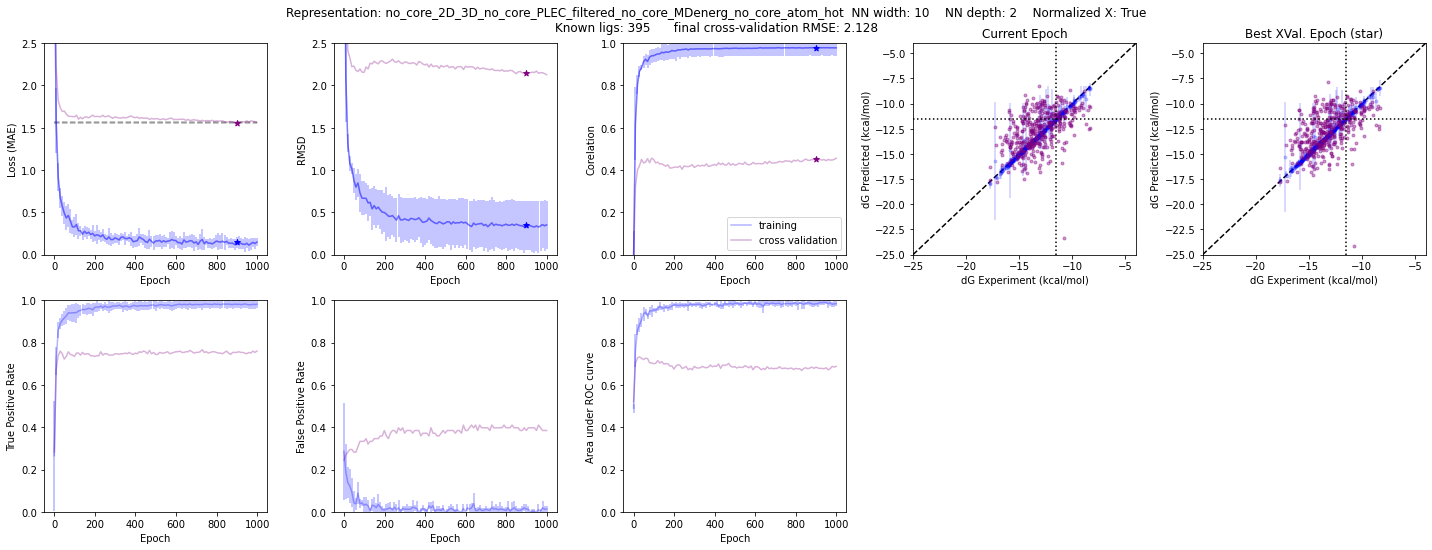

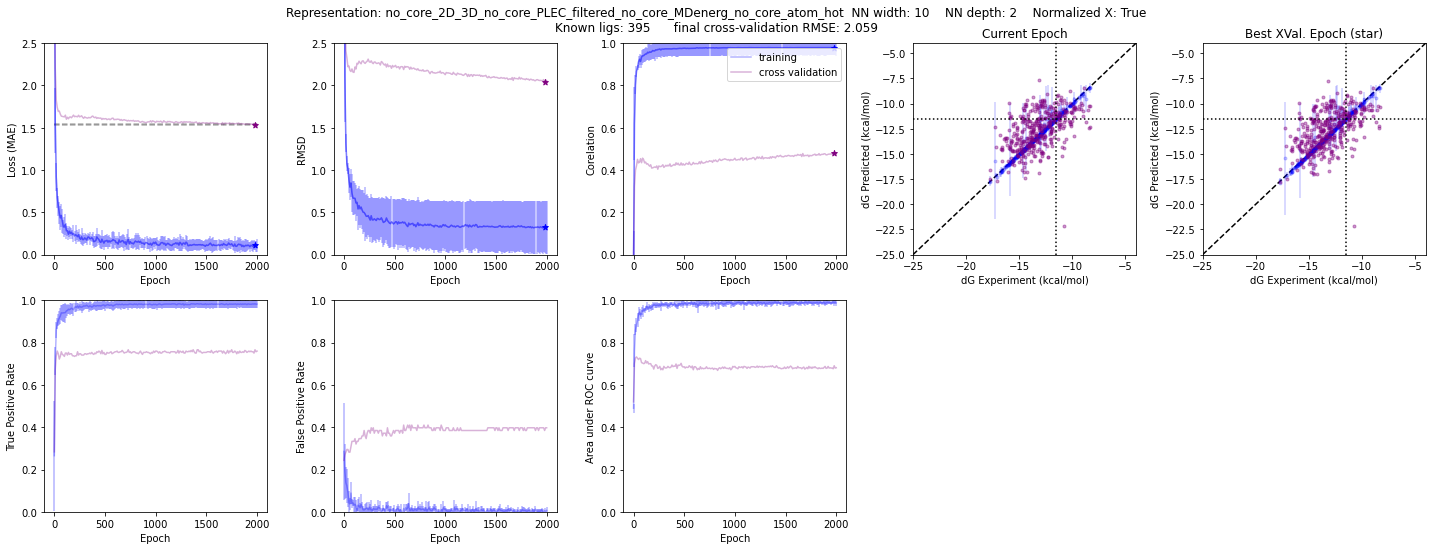

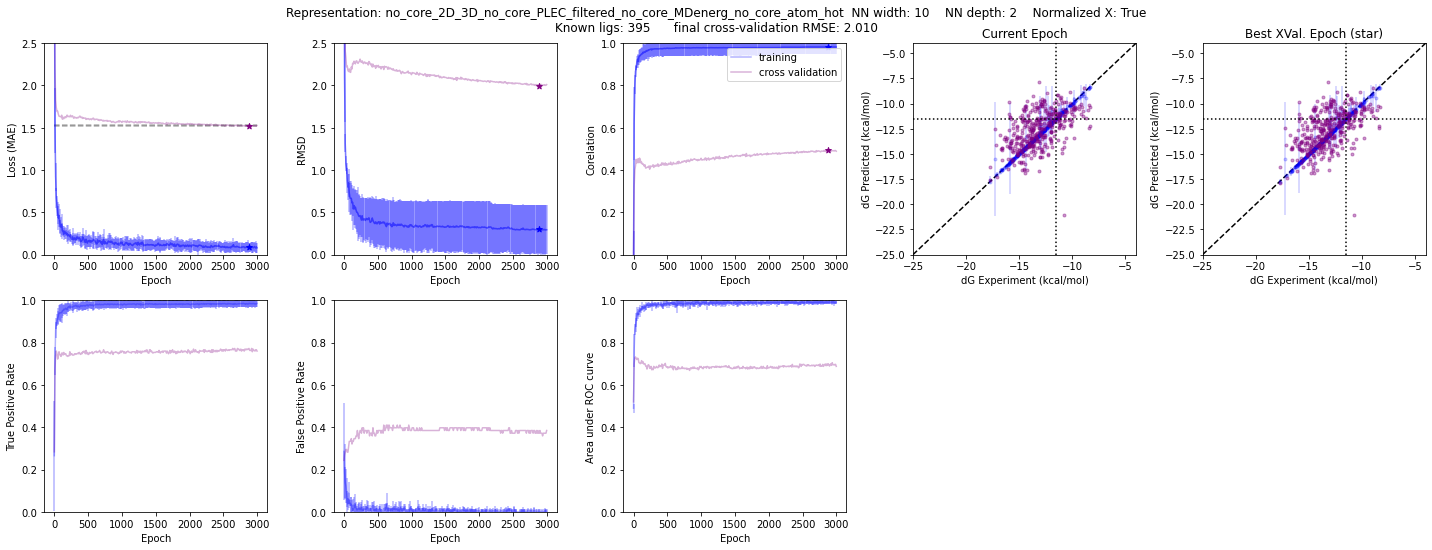

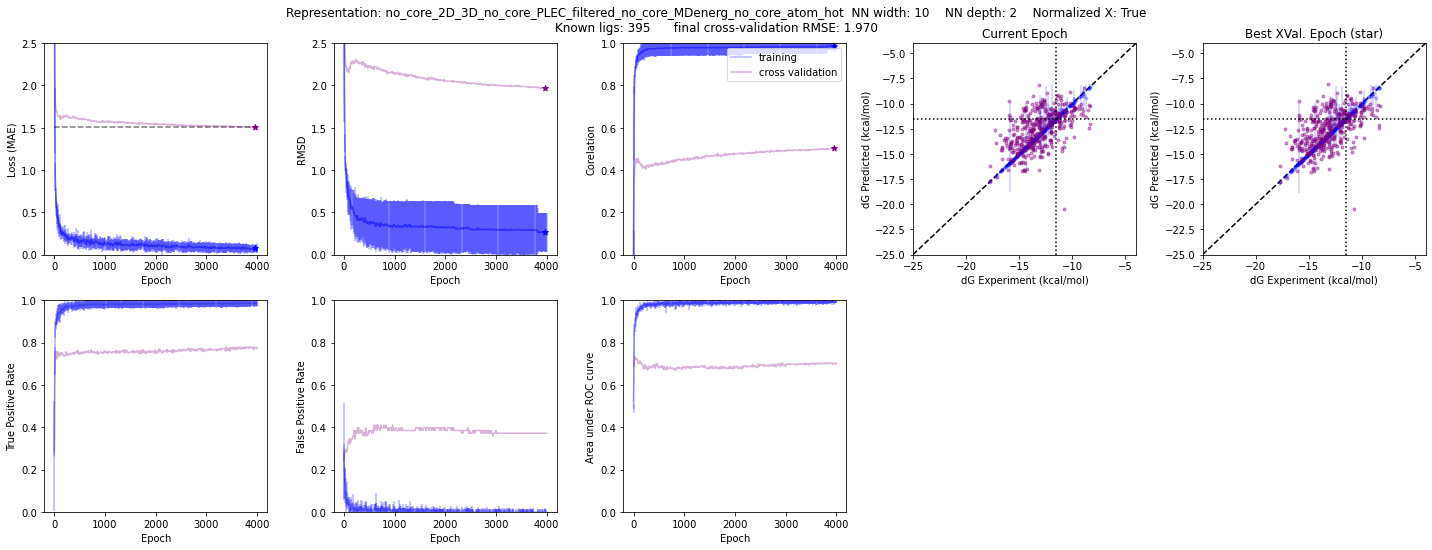

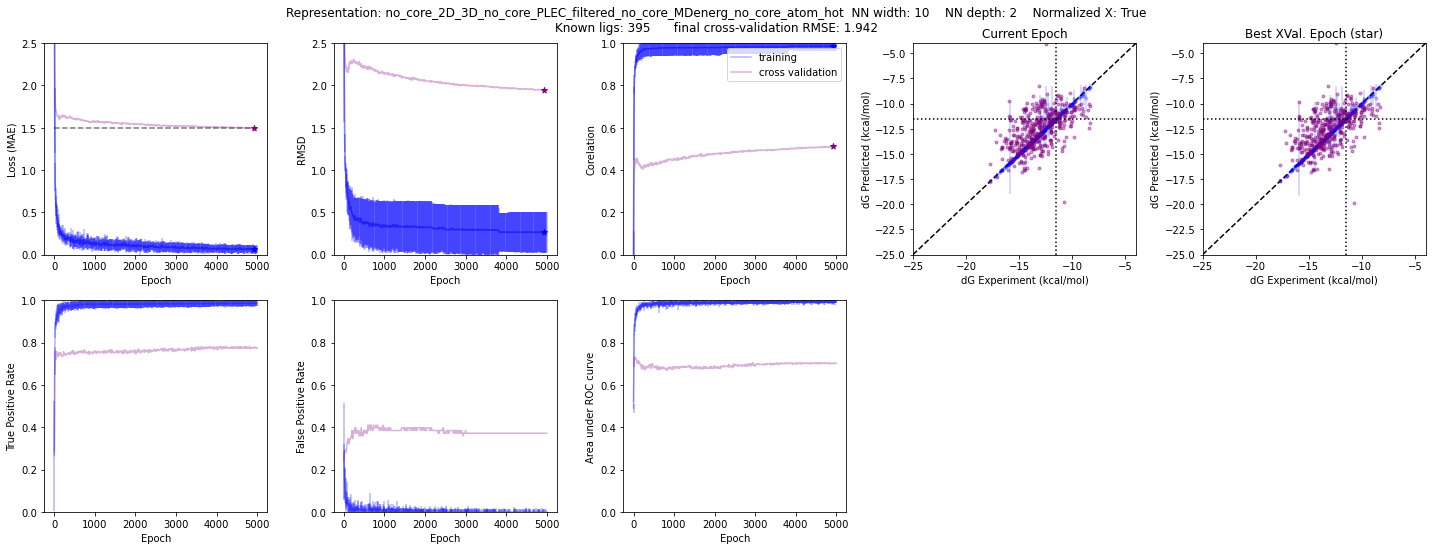

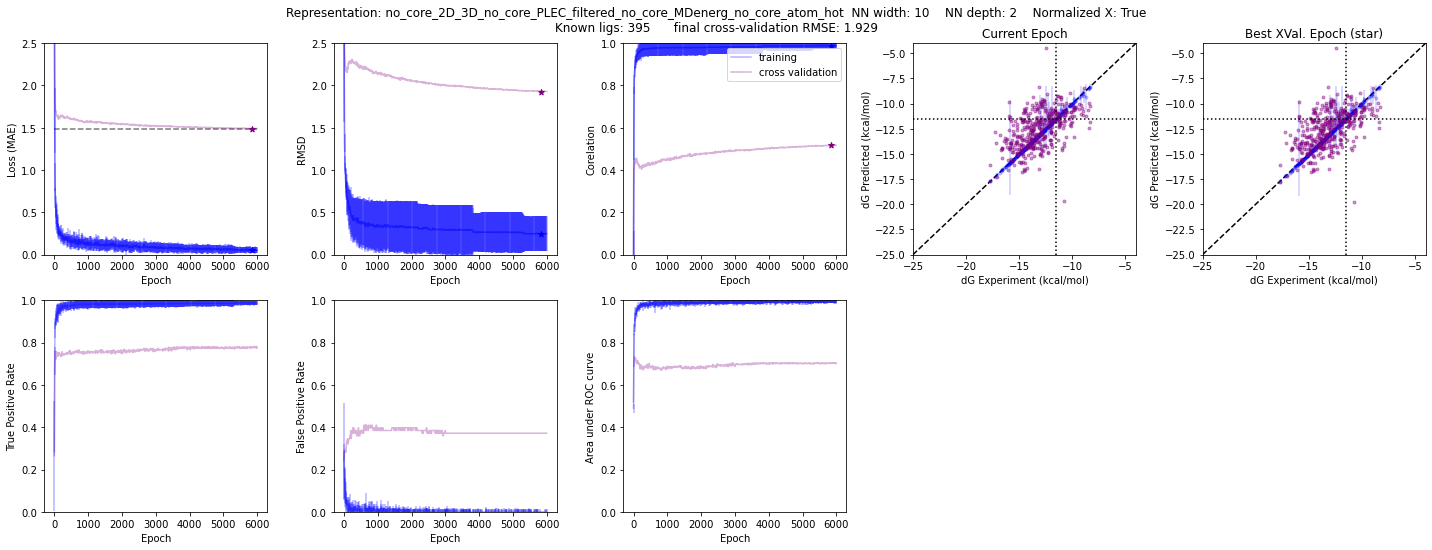

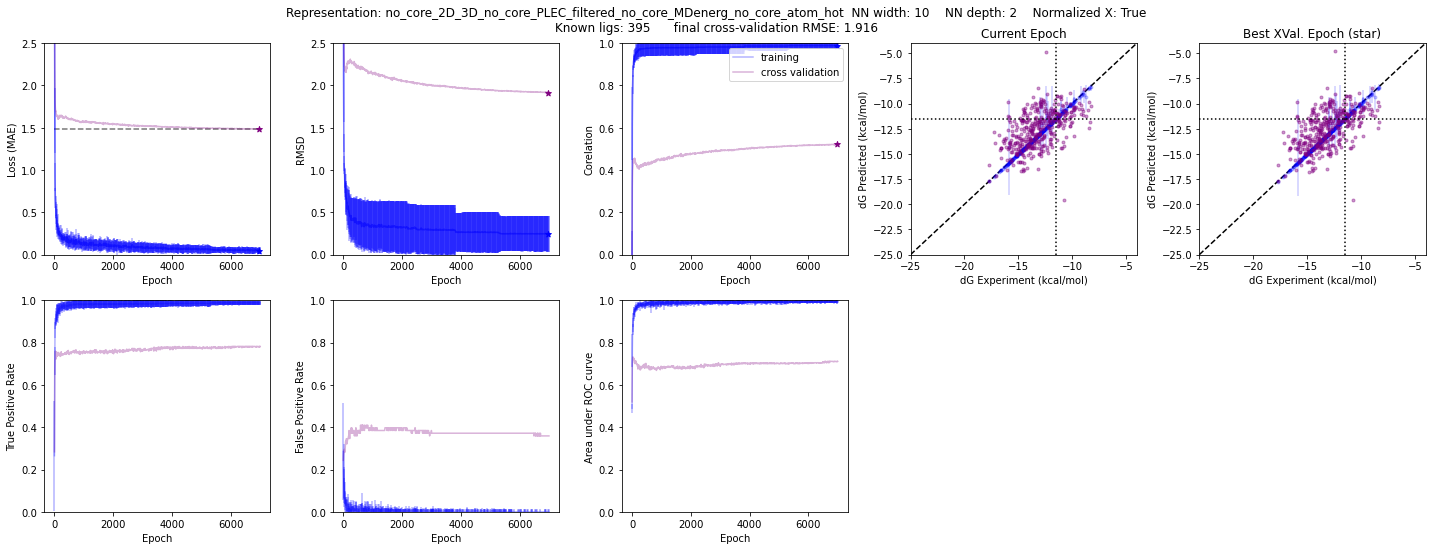

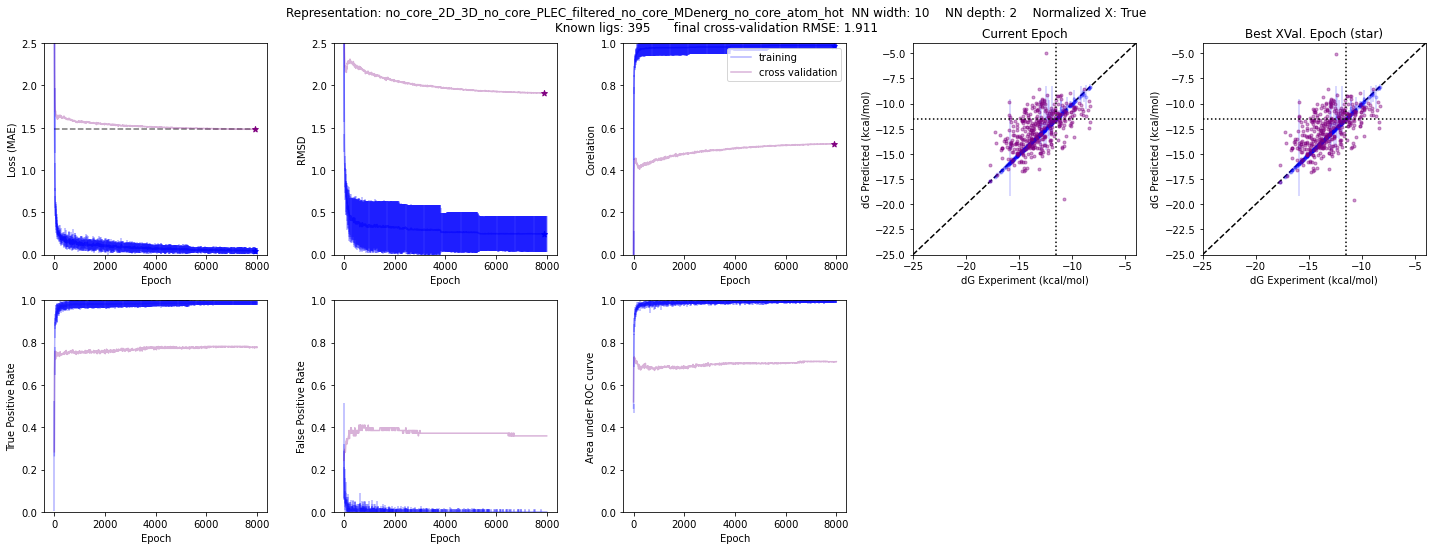

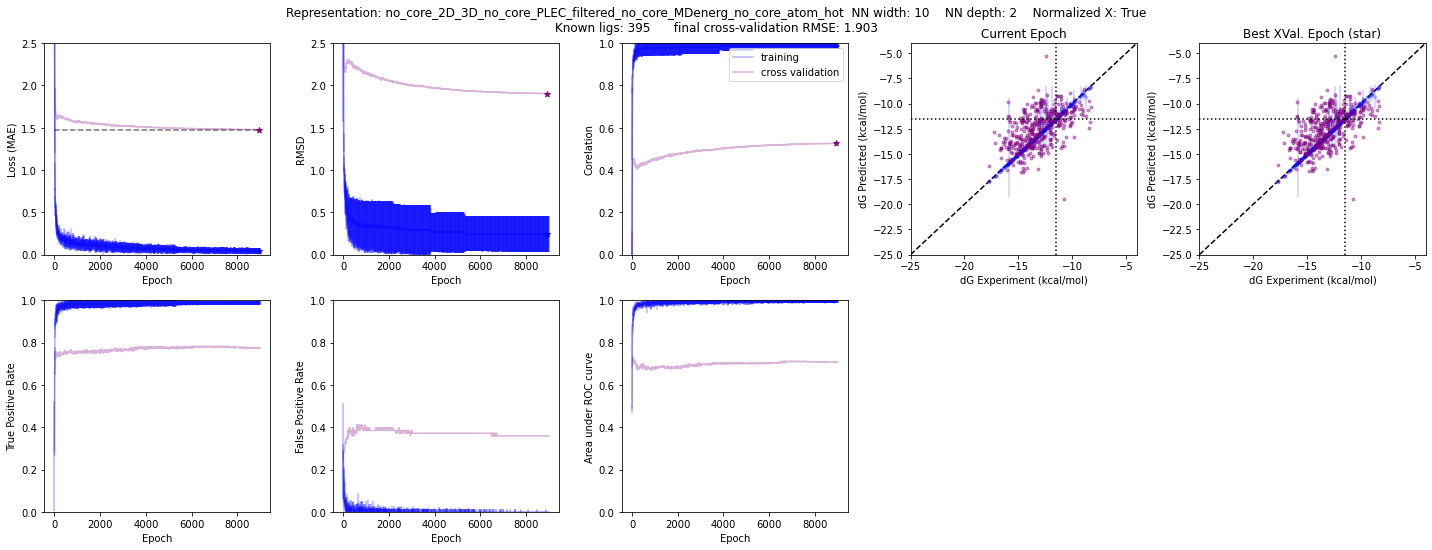

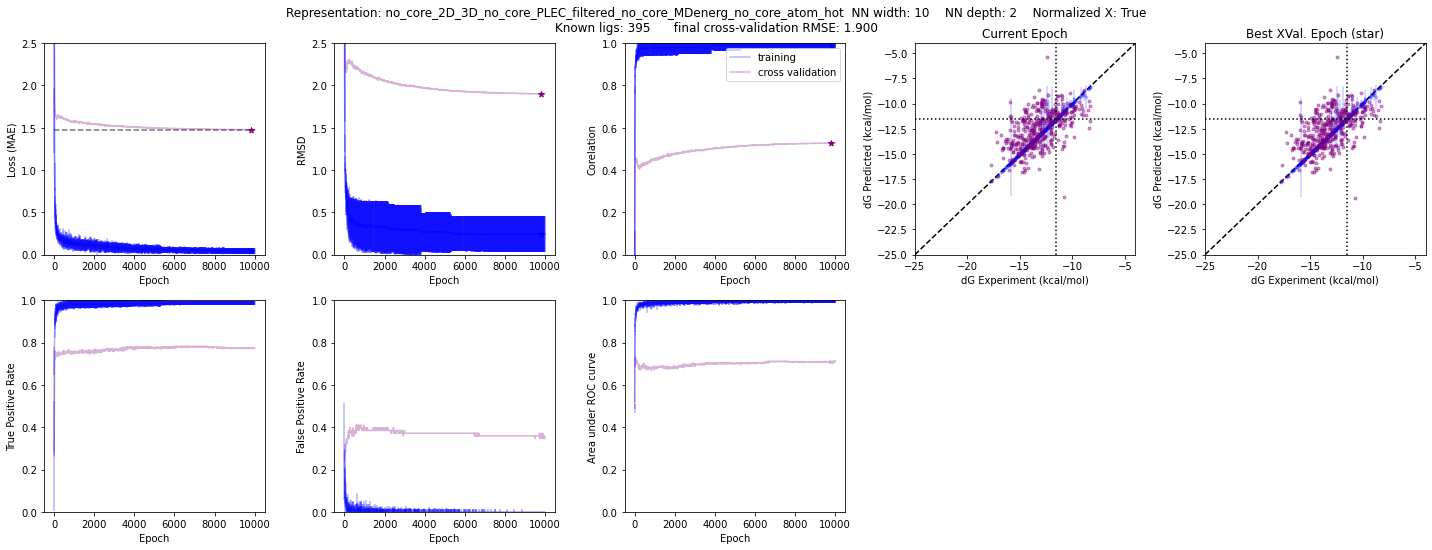

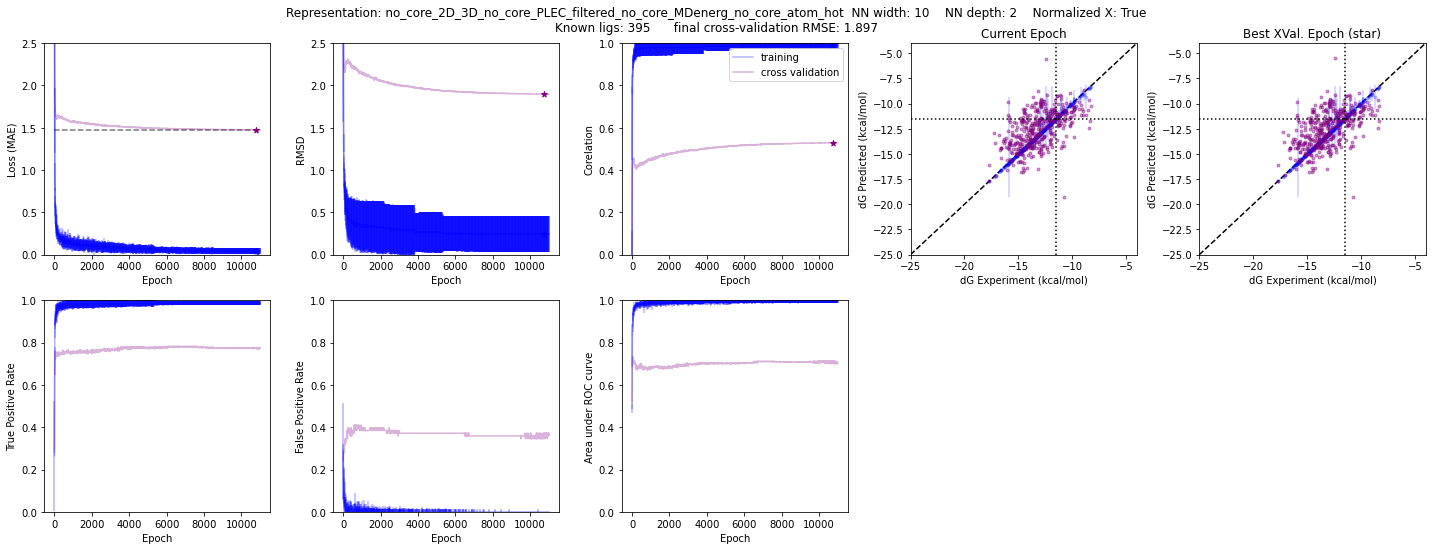

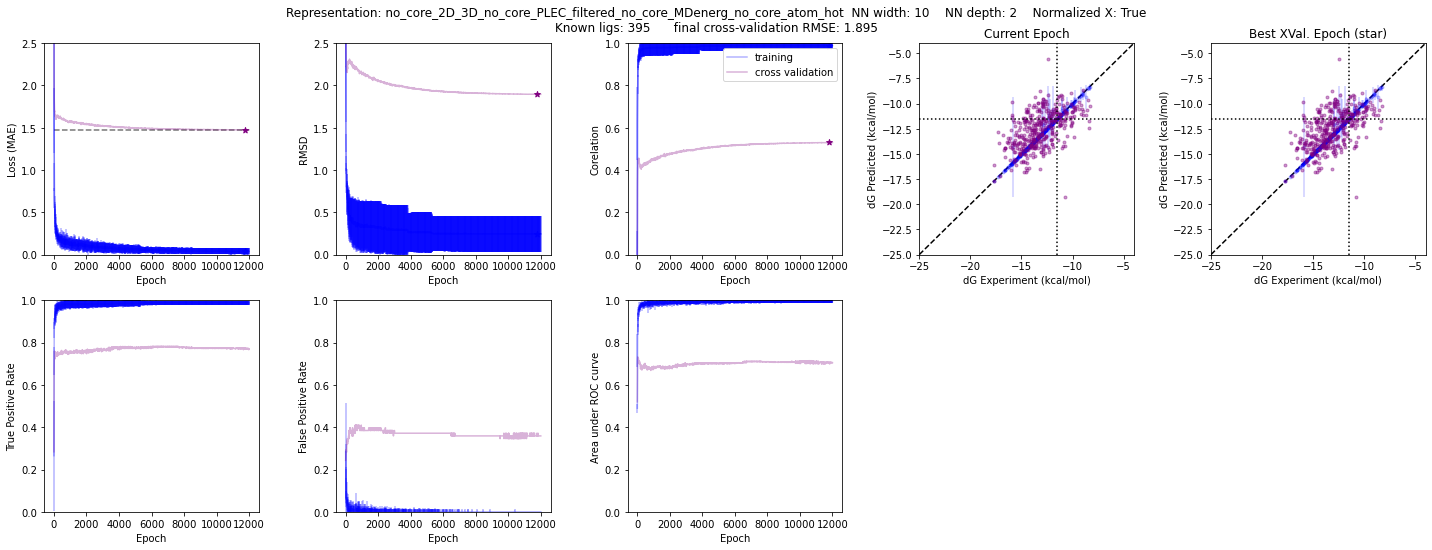

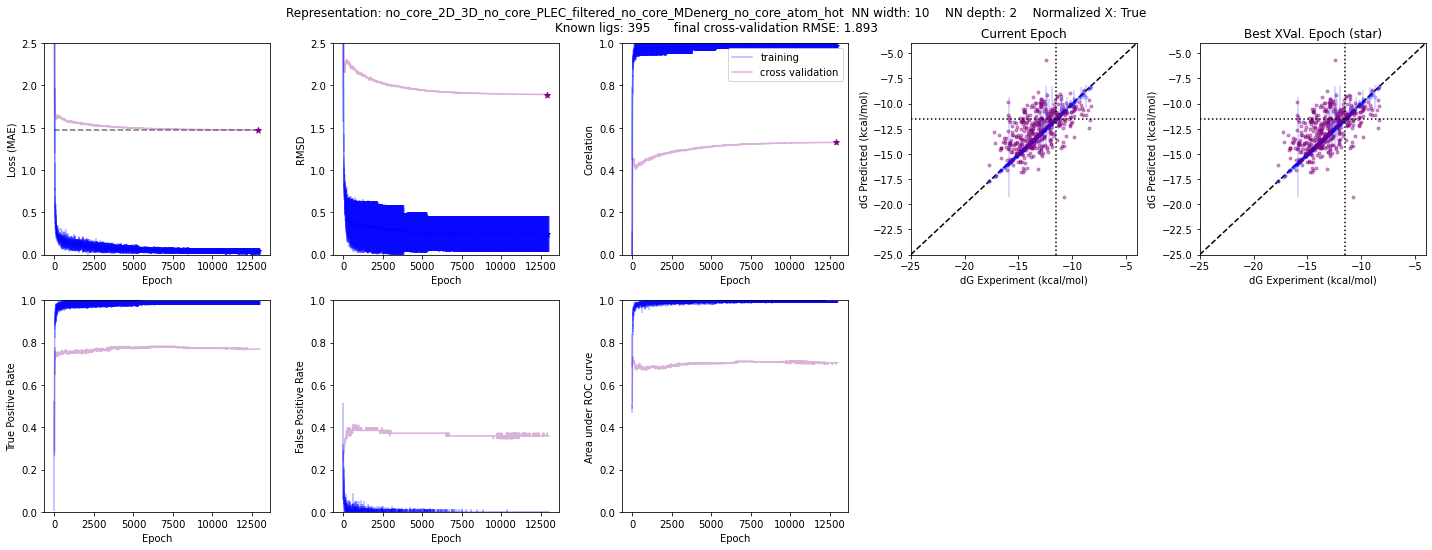

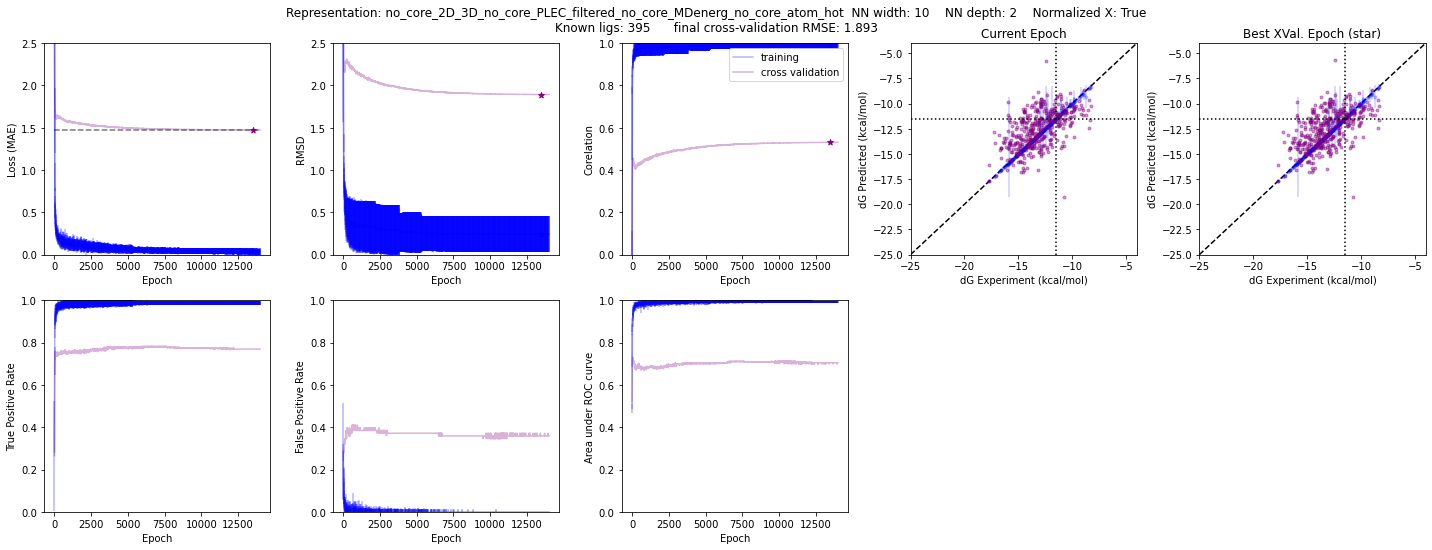

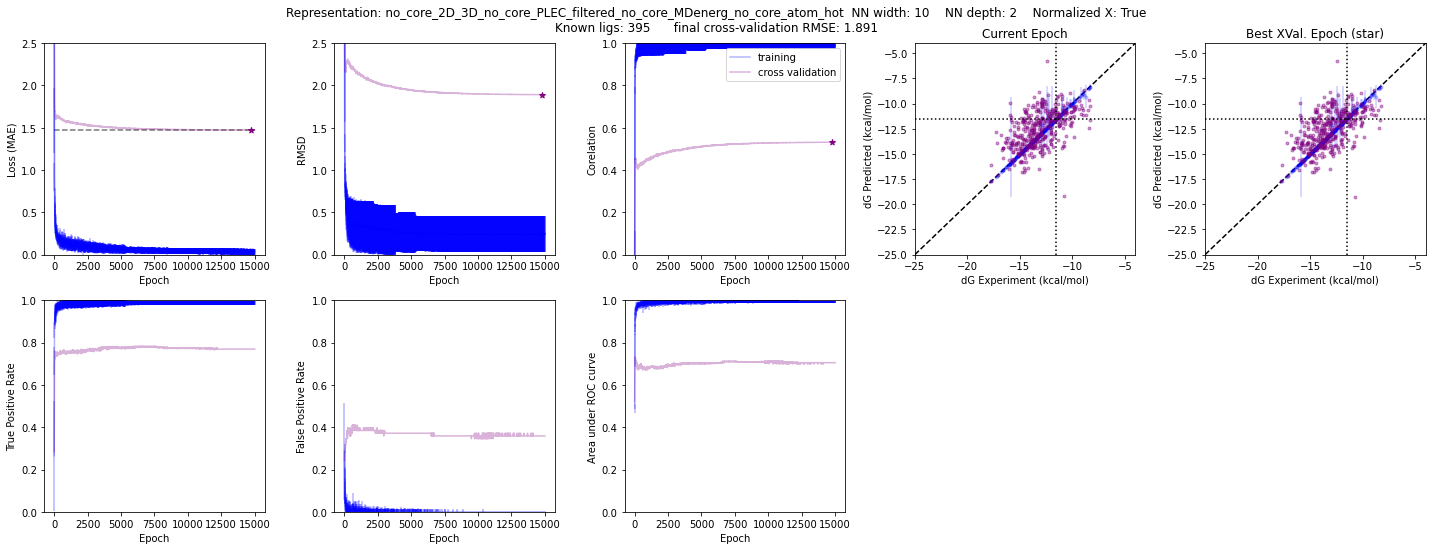

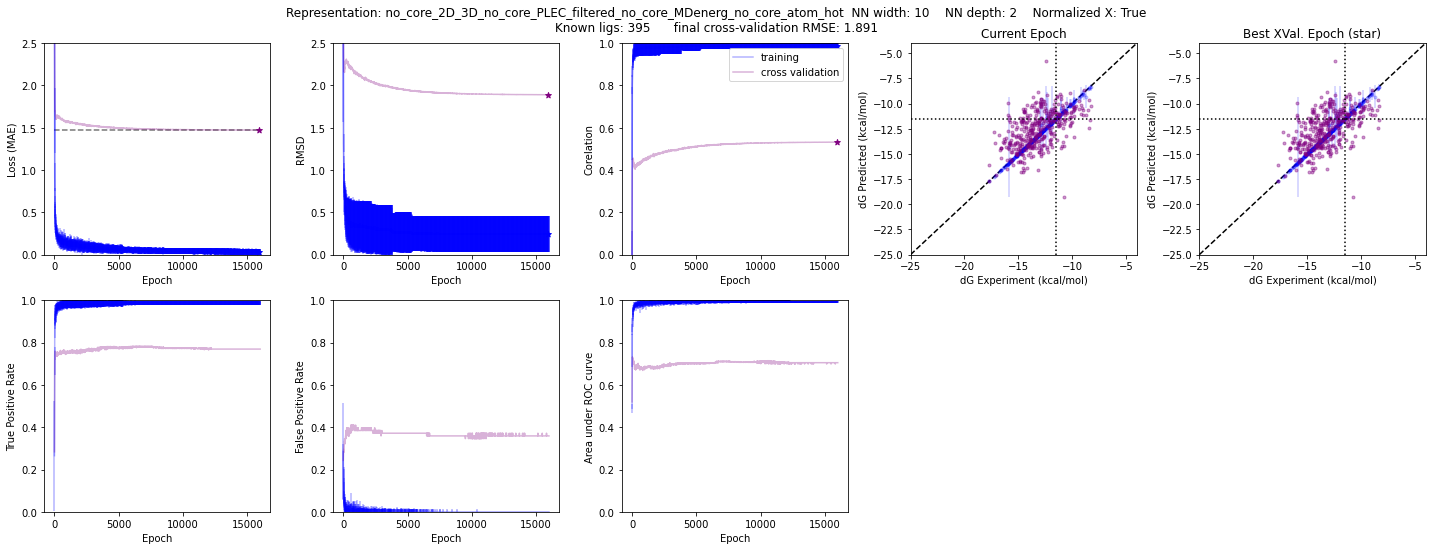

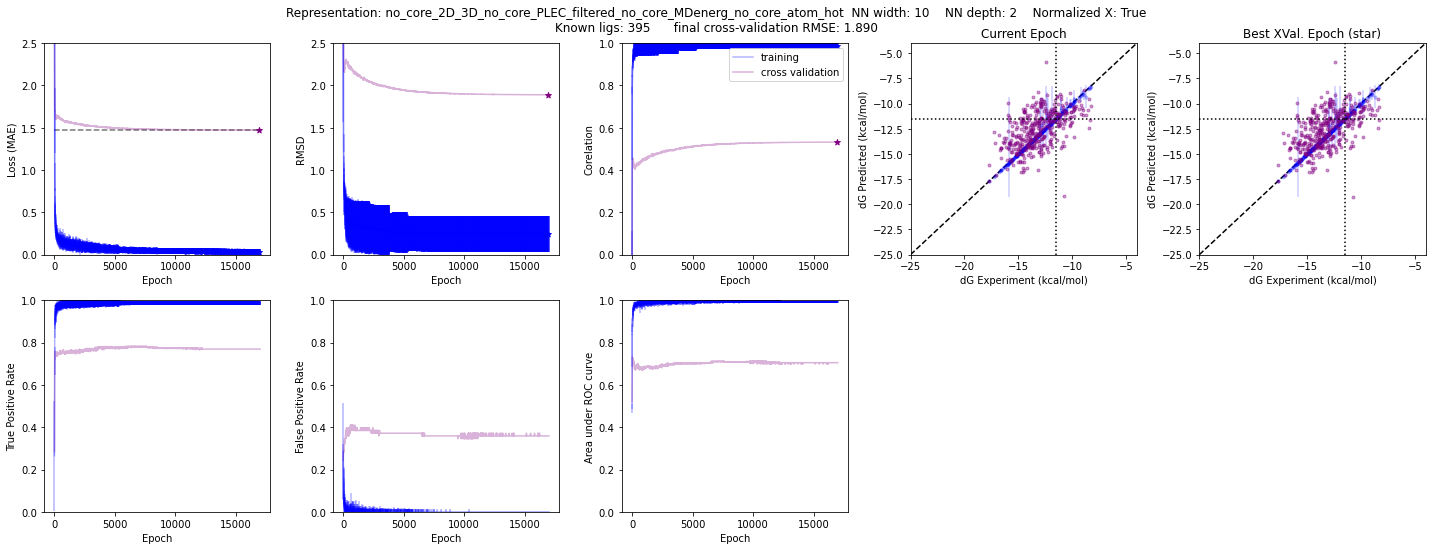

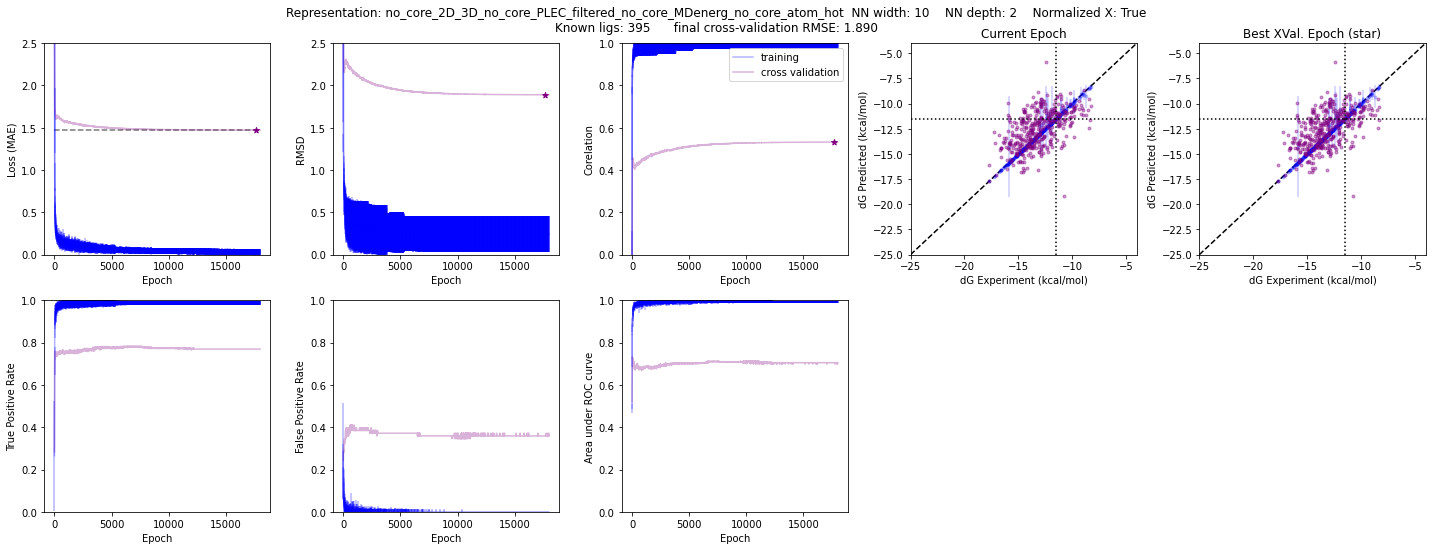

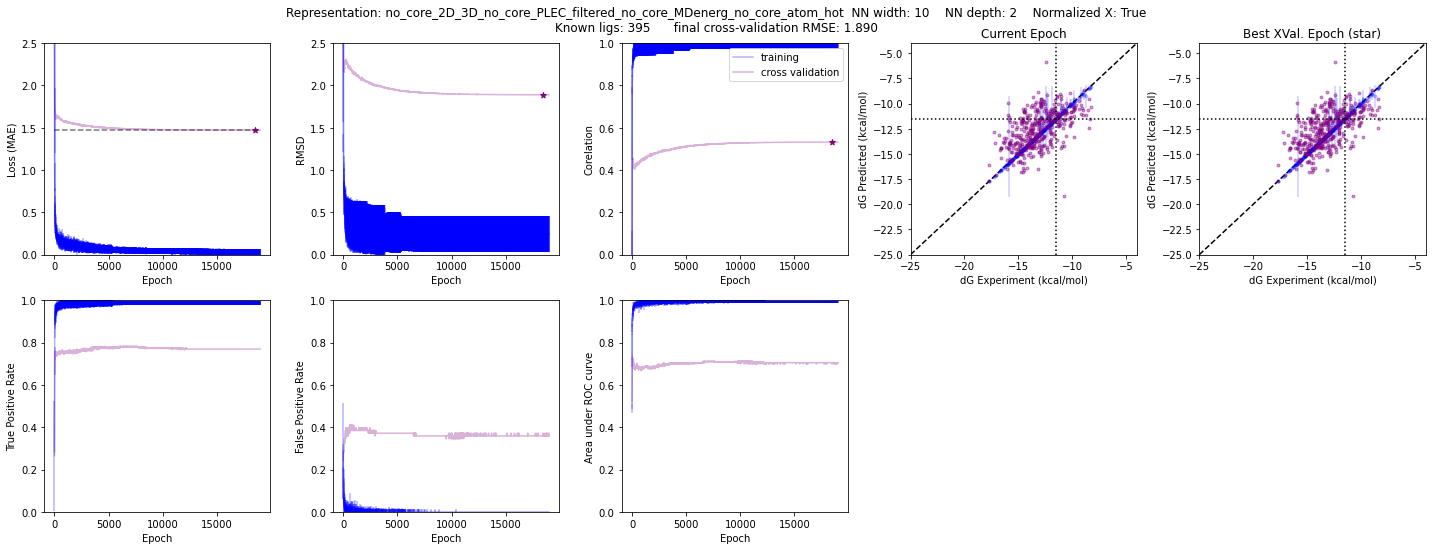

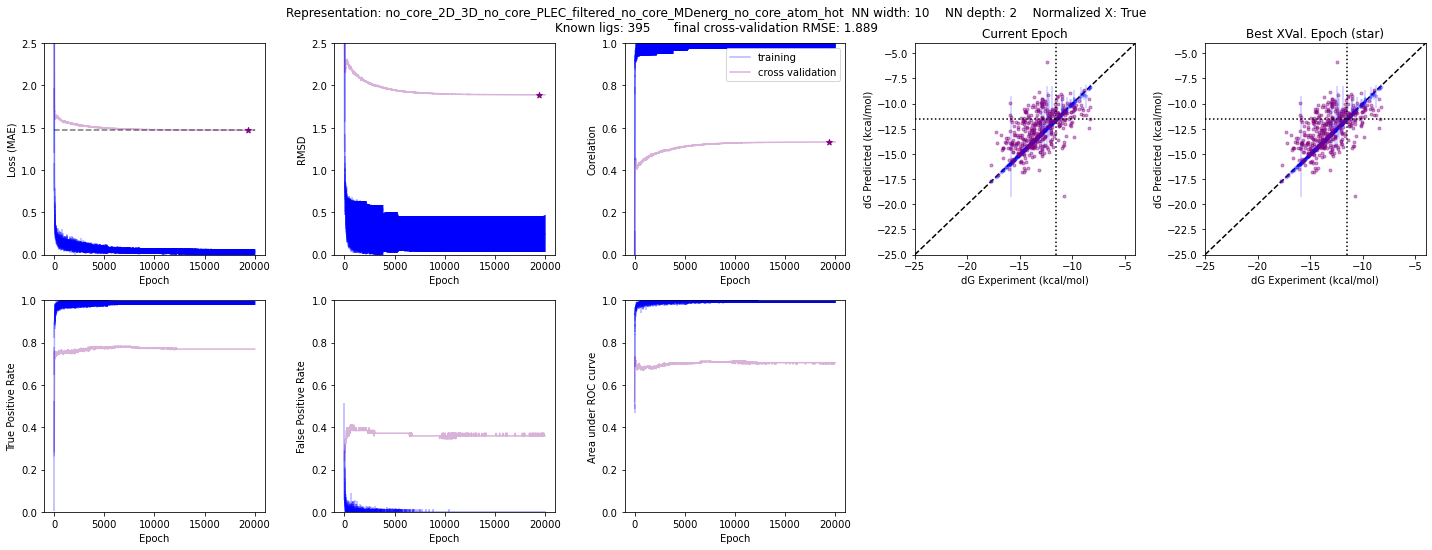

In [58]:
import queue
import threading

previously_done=0
max_debug_evals=10e8

sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

q = queue.Queue()
for f in tqdm(sfiles):
    settings_fname=settings_folder+"/"+f
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        if(metrics is None):
            q.put(settings_fname)
            #print(settings_fname)
            if(q.qsize()>=max_debug_evals):
                break;
        else:
            previously_done+=1

print("previously_done:", previously_done, "\t out of:", len(sfiles), flush=True)
nleft=len(sfiles)-previously_done
nworkers=max(min(30, nleft), 1)
n_per_worker=int(np.ceil(float(nleft)/nworkers))
print("settings left:", nleft, "\t # workers:", nworkers, "\t # settings/worker:", n_per_worker)

# raise()

cwd=folder+"/meta_param_search/local_runs/"
cmd_str=f"source /etc/profile; module load sge; cd {cwd};"
cmd_str_SLURM=f"source /etc/profile; cd {cwd};"

def worker(job_id):
    ligands_str=""
    for l in range(n_per_worker):
        fname = q.get()
        if fname is None:  # EOF?
            break
        ligands_str+=" "+fname
    os.makedirs(cwd, exist_ok=True)
#     jobscript_str=f"""#!/bin/bash

# source ~/.ML_v2_profile

# export NSLOTS=4
# export OMP_NUM_THREADS=$NSLOTS
# export MKL_NUM_THREADS=$NSLOTS

# #echo NHOSTS=$NSLOTS
# #echo OMP_NUM_THREADS=$OMP_NUM_THREADS

# cd {cwd}

# python /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_1/owl_trainer_w_params.py -v -f {ligands_str} > {cwd}/joblog_{job_id}.log 2>&1

# """
#     jobscript_fn=cwd+"/jobscript_{}".format(job_id)
#     with open(jobscript_fn,"w") as f:
#         f.write(jobscript_str)

#     print("Running job_id", job_id, ligands_str)
#     process = subprocess.Popen(["bash", jobscript_fn], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     outs, _ = process.communicate()
#     print()
#     print(outs.decode('utf-8'))
#     process.wait()
# #     raise()

    train_model_with_settings_general(ligands_str[1:], False,
                                      torch.device("cpu"), #torch.device("cuda:0"),
                                      True, datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0",
                                      save_folder_base=f"{pocket_fit_folder}/prediction_step_3/combined_repr_search",
                                      all_ligs_db_file=all_ligs_db_file,
                                      all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step3_dG.pickle"
                                     )
#     raise()

for job_id in range(nworkers):
    q.put(None)
    worker(job_id)

print("Done.")

# Find and cache the normalization factors for all representations

In [11]:
import queue
import threading

from datetime import datetime
import hashlib

previously_done=0
max_debug_evals=10e8

sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0"

q = queue.Queue()
for f in tqdm(sfiles):
    settings_fname=settings_folder+"/"+f
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        
        representation_flags=settings_loaded[0]
        repr_hash=str(abs(hash(np.array(representation_flags, dtype=int).tobytes())))[:5]
        cachefolder=f"{datafolder}/combined_modular_repr_cache/{repr_hash}"
        
        filt_spec="_no_X_filter"
        fn_no_filt=f"{cachefolder}/normalization_factors_{filt_spec}.dat"
        if(not os.path.exists(fn_no_filt)):
            q.put(settings_fname)
            #print(settings_fname)
            if(q.qsize()>=max_debug_evals):
                break;
        else:
            previously_done+=1

print("previously_done:", previously_done, "\t out of:", len(sfiles), flush=True)
nleft=len(sfiles)-previously_done
nworkers=max(min(30, nleft), 1)
n_per_worker=int(np.ceil(float(nleft)/nworkers))
print("settings left:", nleft, "\t # workers:", nworkers, "\t # settings/worker:", n_per_worker)



with open(all_ligs_db_file, 'rb') as f:
    all_ligs = pickle.load(f)

with open(all_no_core_ligs_db_file, 'rb') as f:
    no_core_all_ligs = pickle.load(f)

def worker(job_id):
    for l in range(n_per_worker):
        fname = q.get()
        if fname is None:  # EOF?
            break
        with open(fname, 'rb') as f:
            settings_loaded, metrics = pickle.load(f)
            representation_flags, dr_name, normalize_x, shuffle_seed, n_Epochs, hl_w, hl_depth, init_learning_rate, learning_rate_decay, weight_decay, impfilt, X_filter, weighted, shiftY, use_dropout  = settings_loaded
            
            print(f"Normalizing data for {dr_name}", datetime.now())
            
            #generator for all data
            full_dataset = CustomMolModularDataset(ligs=all_ligs, no_core_ligs=no_core_all_ligs,
                                                    use_combined_cache=False, use_hdf5_cache=False,
                                                    representation_flags=representation_flags, normalize_x=normalize_x,
                                                    X_filter=None, datafolder=datafolder,
                                                    internal_cache_maxMem_MB=0)
            
            full_dataset.find_normalization_factors()
            print("Found normalization factors across all ligands", datetime.now())

            # check presence of cache
            #repr_hash=str(abs(hash(np.array(representation_flags, dtype=int).tobytes())))[:5]
            repr_hash=hashlib.md5(np.packbits(np.array(representation_flags, dtype=bool)).tobytes()).hexdigest()
            cachefolder=f"{datafolder}/combined_modular_repr_cache/{repr_hash}"
            print("cachefolder is:", cachefolder)

            filt_spec="_no_X_filter"
            fn_no_filt=f"{cachefolder}/normalization_factors_{filt_spec}.dat"
            if(not os.path.exists(fn_no_filt)):
                raise(Exception("Could not find normalization cache at:", fn_no_filt))

#     raise()

for job_id in range(nworkers):
    q.put(None)
    worker(job_id)

print("Done.")

100%|██████████| 22/22 [00:00<00:00, 107.90it/s]

previously_done: 22 	 out of: 22


settings left: 0 	 # workers: 1 	 # settings/worker: 0
Done.


### copy normalization cahces to recoverable paths
Turns out hash() is salted with process id and is irreproducible from other python processes.
Need a more stable naming convention for combined_modular_repr_caches

In [ ]:
# can be done with:
# np.packbits(A1).tobytes()

In [20]:
import queue
import threading

import hashlib
import shutil


sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0"

for f in tqdm(sfiles):
    settings_fname=settings_folder+"/"+f
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        
        representation_flags=settings_loaded[0]
        repr_hash=str(abs(hash(np.array(representation_flags, dtype=int).tobytes())))[:5]
        cachefolder=f"{datafolder}/combined_modular_repr_cache/{repr_hash}"
        
        filt_spec="_no_X_filter"
        fn_no_filt=f"{cachefolder}/normalization_factors_{filt_spec}.dat"
        if(os.path.exists(fn_no_filt)):
            #repr_bytes=np.packbits(np.array(representation_flags, dtype=bool)).tobytes()
            repr_bytes=hashlib.md5(np.packbits(np.array(representation_flags, dtype=bool)).tobytes()).hexdigest()
            print(repr_hash, repr_bytes)
            new_cachefolder=f"{datafolder}/combined_modular_repr_cache/{repr_bytes}"
            shutil.copytree(cachefolder, new_cachefolder)
            
print("Done.")

  0%|          | 0/22 [00:00<?, ?it/s]

58186 b78a9e9a2c99b0a577bf377439cd398c


 18%|█▊        | 4/22 [00:02<00:07,  2.42it/s]

52430 b043514b1f9eab7dd765b5a653554cad
25242 705e83e3aefc5fce06360a6988ae135a
90219 d4b52cdfe7a2b48c495835f838f12925
78108 b982be205cf353c26f89186561aa45ac
59476 13be7e3c1f8cd0b18179b1a1e037497b


 32%|███▏      | 7/22 [00:02<00:03,  4.75it/s]

91790 d183428313cc89c115a48051563524b0
39814 8956adab85342f51bd62d45eae777db2
55314 6886f410cfd530dd2b82f3d6320e5cba


 59%|█████▉    | 13/22 [00:02<00:01,  7.78it/s]

29577 2dbe3ff42b27035eee90bb80e7a42cf6
75950 866bf0cc0e240fee724244d9556aa5f0
21899 f2fd00b286de09c6a149faf459e3bcd7
11522 b0e8e408521544e0fea3c7ee9a34ef4b
23398 c2011b62680f0c4d0ec04e249b5a7e71
36378 4fe971342e96acf33f3ec604b93b917b
83833 7ace295b9bf3329438a72df28a6142bf


 86%|████████▋ | 19/22 [00:03<00:00, 12.51it/s]

61607 beb912253495afffc264ec275fb1bf02
32662 5d3a61bd40dbd87816b87c02d7897085
62996 7c18f3bd2343ff0faf1d5a4a48412805
43196 84e175a52db610b8624c1f26ab1b7893
76335 78184af6025f2e050f581e215eee7246


100%|██████████| 22/22 [00:03<00:00,  6.84it/s]

17452 1261258b644e66870870335d6ec98c91
Done.


## Collect pickles for only the training ligands for all representations

In [21]:
with open(all_ligs_db_file, 'rb') as f:
    all_ligs = pickle.load(f)
    
lig_needed_names=[l.GetProp('ID') for l in all_ligs if l.HasProp('dG')]

del all_ligs
_=gc.collect()

In [22]:
print(len(lig_needed_names))

395


In [29]:
import queue
import threading

from datetime import datetime
import shutil
import hashlib

n_todo=0
previously_done=0
max_debug_evals=10e8

grid_size_dependent_data_blocks=[]
for i in range(len(dataBlocks)):
    if("ESP" in dataBlocks(i).name or "atom_hot" in dataBlocks(i).name):
        grid_size_dependent_data_blocks.append(i)

sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0"
new_datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_3/combined_repr_search"
os.makedirs(new_datafolder, exist_ok=True)

q = queue.Queue()
for f in tqdm(sfiles):
    settings_fname=settings_folder+"/"+f
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        
        representation_flags=settings_loaded[0]
        #repr_hash=str(abs(hash(np.array(representation_flags, dtype=int).tobytes())))[:5]
        repr_hash=hashlib.md5(np.packbits(np.array(representation_flags, dtype=bool)).tobytes()).hexdigest()
        cachefolder=f"{datafolder}/combined_modular_repr_cache/{repr_hash}"
        
        filt_spec="_no_X_filter"
        fn_no_filt=f"{cachefolder}/normalization_factors_{filt_spec}.dat"
#         print(fn_no_filt)
        if(os.path.exists(fn_no_filt)):
            if(not os.path.exists(f"{new_datafolder}/modular_repr_cache/MOE/{lig_needed_names[-1]}.pickle")):
                q.put(settings_fname)
                #print(settings_fname)
                if(q.qsize()>=max_debug_evals):
                    break;
            else:
                previously_done+=1
            n_todo+=1

print("previously_done:", previously_done, "\t out of:", n_todo, flush=True)
nleft=n_todo-previously_done
nworkers=max(min(30, nleft), 1)
n_per_worker=int(np.ceil(float(nleft)/nworkers))
print("settings left:", nleft, "\t # workers:", nworkers, "\t # settings/worker:", n_per_worker)



with open(all_ligs_db_file, 'rb') as f:
    all_ligs = pickle.load(f)

with open(all_no_core_ligs_db_file, 'rb') as f:
    no_core_all_ligs = pickle.load(f)

def worker(job_id):
    for l in range(n_per_worker):
        fname = q.get()
        if fname is None:  # EOF?
            break
        with open(fname, 'rb') as f:
            settings_loaded, metrics = pickle.load(f)
            representation_flags, dr_name, normalize_x, shuffle_seed, n_Epochs, hl_w, hl_depth, init_learning_rate, learning_rate_decay, weight_decay, impfilt, X_filter, weighted, shiftY, use_dropout  = settings_loaded
            
            # copy the ligand pickles
            for i in range(len(representation_flags)):
                if(representation_flags[i]):
                    #where are the block chaches?
                    old_cache_folder=datafolder+"/modular_repr_cache/"+dataBlocks(i).name+"/"
                    new_cache_folder=new_datafolder+"/modular_repr_cache/"+dataBlocks(i).name+"/"
                    if(i in grid_size_dependent_data_blocks):
                        grid_spacing=2
                        grid_padding=4
                        old_cache_folder=datafolder+"/modular_repr_cache/{}_p_{}_a_{}/".format(
                            dataBlocks(i).name, grid_padding, grid_spacing)
                        new_cache_folder=new_datafolder+"/modular_repr_cache/{}_p_{}_a_{}/".format(
                            dataBlocks(i).name, grid_padding, grid_spacing)
                    os.makedirs(new_cache_folder, exist_ok=True)
                    
                    if(not os.path.exists(f"{new_cache_folder}/{lig_needed_names[-1]}.pickle")):
                        for name in lig_needed_names:
                            shutil.copyfile(f"{old_cache_folder}/{name}.pickle",
                                            f"{new_cache_folder}/{name}.pickle")
                            
            # also copy the normalization cache
            #repr_hash=str(abs(hash(np.array(representation_flags, dtype=int).tobytes())))[:5]
            repr_hash=hashlib.md5(np.packbits(np.array(representation_flags, dtype=bool)).tobytes()).hexdigest()
            old_cachefolder=f"{datafolder}/combined_modular_repr_cache/{repr_hash}"
            filt_spec="_no_X_filter"
            old_fn_no_filt=f"{old_cachefolder}/normalization_factors_{filt_spec}.dat"
            
            new_cachefolder=f"{new_datafolder}/combined_modular_repr_cache/{repr_hash}"
            os.makedirs(new_cachefolder, exist_ok=True)
            new_fn_no_filt=f"{new_cachefolder}/normalization_factors_{filt_spec}.dat"
            
            shutil.copyfile(old_fn_no_filt, new_fn_no_filt)

# raise()

for job_id in range(nworkers):
    q.put(None)
    
    worker(job_id)

print("Done.")

100%|██████████| 22/22 [00:00<00:00, 1463.93it/s]

previously_done: 0 	 out of: 22


settings left: 22 	 # workers: 22 	 # settings/worker: 1
Done.


# Run training locally without prediction
as a test before unloading to owl/moa

In [44]:
if 'custom_dataset_modular_with_binning' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning'])
else:
    import custom_dataset_modular_with_binning
from custom_dataset_modular_with_binning import dataBlocks, CustomMolModularDataset

if 'owl_trainer_w_params_general' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_general'])
else:
    import owl_trainer_w_params_general
from owl_trainer_w_params_general import *

In [ ]:
import queue
import threading

previously_done=0
max_debug_evals=10e8

sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

q = queue.Queue()
for f in tqdm(sfiles):
    settings_fname=settings_folder+"/"+f
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        if(metrics is None):
            q.put(settings_fname)
            #print(settings_fname)
            if(q.qsize()>=max_debug_evals):
                break;
        else:
            previously_done+=1

print("previously_done:", previously_done, "\t out of:", len(sfiles), flush=True)
nleft=len(sfiles)-previously_done
nworkers=max(min(30, nleft), 1)
n_per_worker=int(np.ceil(float(nleft)/nworkers))
print("settings left:", nleft, "\t # workers:", nworkers, "\t # settings/worker:", n_per_worker)

# raise()

cwd=folder+"/meta_param_search/local_runs/"
cmd_str=f"source /etc/profile; module load sge; cd {cwd};"
cmd_str_SLURM=f"source /etc/profile; cd {cwd};"

def worker(job_id):
    ligands_str=""
    for l in range(n_per_worker):
        fname = q.get()
        if fname is None:  # EOF?
            break
        ligands_str+=" "+fname
    os.makedirs(cwd, exist_ok=True)


    train_model_with_settings_general(ligands_str[1:], False,
                                      torch.device("cpu"), #torch.device("cuda:0"),
                                      True,
                                      #datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0",
                                      datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_3/combined_repr_search",
                                      save_folder_base=f"{pocket_fit_folder}/prediction_step_3/combined_repr_search",
                                      all_ligs_db_file=all_ligs_db_file,
                                      all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step3_dG.pickle",
                                      predict_all_ligs=False
                                     )
    raise()

for job_id in range(nworkers):
    q.put(None)
    worker(job_id)

print("Done.")

100%|██████████| 22/22 [00:00<00:00, 1333.93it/s]

previously_done: 1 	 out of: 22
settings left: 21 	 # workers: 21 	 # settings/worker: 1




Representation is: PLEC_filtered_atom_hot


# of training ligands found: 395 2022-02-02 18:30:11.237314
# starting ligands: 395 2022-02-02 18:30:11.383519
Finished setting up weights 2022-02-02 18:30:11.384548
Building the internal_filtered_cache needs 2786.181411743164 MB, more than the 512.0 MB limit. SKIPPING and will read samples from HDD each time instead.
Found normalization factors across all ligands 2022-02-02 18:30:18.393502
Start setting up models 2022-02-02 18:30:18.394079
Finished setup for model 0 2022-02-02 18:30:18.639795
Finished setup for model 1 2022-02-02 18:30:18.883306
Finished setup for model 2 2022-02-02 18:30:19.124264
Finished setup for model 3 2022-02-02 18:30:19.366581
Finished setup for model 4 2022-02-02 18:30:19.607553
Training for 20000 epochs 2022-02-02 18:30:19.607687
	Epoch: 0	 train_loss=4.197749423980713	 XVal_RMSE=5.808230400085449
	Epoch: 9	 train_loss=1.9512381553649902	 XVal_RMSE=4.118049621582031
	Epoch: 19	 train_loss=1.2525095701217652	 XVal_RMSE=3.445936441421509
	Epoch: 29	 train_loss

	Epoch: 1019	 train_loss=0.10785950422286987	 XVal_RMSE=2.493540048599243
	Epoch: 1029	 train_loss=0.10465939342975616	 XVal_RMSE=2.4948484897613525
	Epoch: 1039	 train_loss=0.11123592853546142	 XVal_RMSE=2.5026752948760986
	Epoch: 1049	 train_loss=0.10528676211833954	 XVal_RMSE=2.4974606037139893
	Epoch: 1059	 train_loss=0.10303807556629181	 XVal_RMSE=2.491407871246338
	Epoch: 1069	 train_loss=0.10811160057783127	 XVal_RMSE=2.485100507736206
	Epoch: 1079	 train_loss=0.11315092593431472	 XVal_RMSE=2.495166778564453
	Epoch: 1089	 train_loss=0.10825324654579163	 XVal_RMSE=2.486727476119995
	Epoch: 1099	 train_loss=0.11022415459156036	 XVal_RMSE=2.488743543624878
	Epoch: 1109	 train_loss=0.10621303617954254	 XVal_RMSE=2.491192579269409
	Epoch: 1119	 train_loss=0.11051138639450073	 XVal_RMSE=2.4938390254974365
	Epoch: 1129	 train_loss=0.11399224251508713	 XVal_RMSE=2.4989945888519287
	Epoch: 1139	 train_loss=0.11497948467731475	 XVal_RMSE=2.4936940670013428
	Epoch: 1149	 train_loss=0.10648

	Epoch: 2119	 train_loss=0.08596758693456649	 XVal_RMSE=2.439150333404541
	Epoch: 2129	 train_loss=0.08855409920215607	 XVal_RMSE=2.4425899982452393
	Epoch: 2139	 train_loss=0.08838332891464233	 XVal_RMSE=2.443936347961426
	Epoch: 2149	 train_loss=0.08827001452445984	 XVal_RMSE=2.4400534629821777
	Epoch: 2159	 train_loss=0.08948397934436798	 XVal_RMSE=2.4402942657470703
	Epoch: 2169	 train_loss=0.08869163691997528	 XVal_RMSE=2.439647674560547
	Epoch: 2179	 train_loss=0.09129593968391418	 XVal_RMSE=2.44037127494812
	Epoch: 2189	 train_loss=0.08963049501180649	 XVal_RMSE=2.440680980682373
	Epoch: 2199	 train_loss=0.08754263520240783	 XVal_RMSE=2.439722776412964
	Epoch: 2209	 train_loss=0.08970662653446197	 XVal_RMSE=2.4417223930358887
	Epoch: 2219	 train_loss=0.09306359589099884	 XVal_RMSE=2.439274311065674
	Epoch: 2229	 train_loss=0.09579184651374817	 XVal_RMSE=2.441521167755127
	Epoch: 2239	 train_loss=0.08371369391679764	 XVal_RMSE=2.4393229484558105
	Epoch: 2249	 train_loss=0.0859770

	Epoch: 3219	 train_loss=0.08138376623392105	 XVal_RMSE=2.4172561168670654
	Epoch: 3229	 train_loss=0.07452605813741683	 XVal_RMSE=2.4170069694519043
	Epoch: 3239	 train_loss=0.07655124068260193	 XVal_RMSE=2.414019823074341
	Epoch: 3249	 train_loss=0.07277369052171707	 XVal_RMSE=2.414351224899292
	Epoch: 3259	 train_loss=0.0754042997956276	 XVal_RMSE=2.4129512310028076
	Epoch: 3269	 train_loss=0.0757307730615139	 XVal_RMSE=2.414501428604126
	Epoch: 3279	 train_loss=0.07622173056006432	 XVal_RMSE=2.4145994186401367
	Epoch: 3289	 train_loss=0.07401252165436745	 XVal_RMSE=2.4145119190216064
	Epoch: 3299	 train_loss=0.07897574305534363	 XVal_RMSE=2.4096362590789795
	Epoch: 3309	 train_loss=0.07626441568136215	 XVal_RMSE=2.4102532863616943
	Epoch: 3319	 train_loss=0.07769524455070495	 XVal_RMSE=2.41379976272583
	Epoch: 3329	 train_loss=0.07975863292813301	 XVal_RMSE=2.413078784942627
	Epoch: 3339	 train_loss=0.07560790628194809	 XVal_RMSE=2.415069818496704
	Epoch: 3349	 train_loss=0.0725640

	Epoch: 4319	 train_loss=0.07274597436189652	 XVal_RMSE=2.4051127433776855
	Epoch: 4329	 train_loss=0.07133646309375763	 XVal_RMSE=2.4044675827026367
	Epoch: 4339	 train_loss=0.07057503014802932	 XVal_RMSE=2.4074866771698
	Epoch: 4349	 train_loss=0.06727169454097748	 XVal_RMSE=2.406571388244629
	Epoch: 4359	 train_loss=0.0667922854423523	 XVal_RMSE=2.4067983627319336
	Epoch: 4369	 train_loss=0.06715116053819656	 XVal_RMSE=2.40436053276062
	Epoch: 4379	 train_loss=0.06821755692362785	 XVal_RMSE=2.4071755409240723
	Epoch: 4389	 train_loss=0.0673793986439705	 XVal_RMSE=2.4055423736572266
	Epoch: 4399	 train_loss=0.06774149909615516	 XVal_RMSE=2.408146381378174
	Epoch: 4409	 train_loss=0.06752462908625603	 XVal_RMSE=2.404846668243408
	Epoch: 4419	 train_loss=0.06971152573823929	 XVal_RMSE=2.4064602851867676
	Epoch: 4429	 train_loss=0.06948298439383507	 XVal_RMSE=2.4046106338500977
	Epoch: 4439	 train_loss=0.06926661208271981	 XVal_RMSE=2.4063076972961426
	Epoch: 4449	 train_loss=0.07084123

	Epoch: 5419	 train_loss=0.06254486665129662	 XVal_RMSE=2.40299391746521
	Epoch: 5429	 train_loss=0.062153372913599014	 XVal_RMSE=2.403411865234375
	Epoch: 5439	 train_loss=0.06191907078027725	 XVal_RMSE=2.4040286540985107
	Epoch: 5449	 train_loss=0.06310237571597099	 XVal_RMSE=2.403158187866211
	Epoch: 5459	 train_loss=0.06359611675143242	 XVal_RMSE=2.4047162532806396
	Epoch: 5469	 train_loss=0.06546500846743583	 XVal_RMSE=2.4027979373931885
	Epoch: 5479	 train_loss=0.060944437980651855	 XVal_RMSE=2.4034054279327393
	Epoch: 5489	 train_loss=0.06271515041589737	 XVal_RMSE=2.402298927307129
	Epoch: 5499	 train_loss=0.06468871682882309	 XVal_RMSE=2.4052505493164062
	Epoch: 5509	 train_loss=0.06292874738574028	 XVal_RMSE=2.4032607078552246
	Epoch: 5519	 train_loss=0.062102001160383224	 XVal_RMSE=2.403752088546753
	Epoch: 5529	 train_loss=0.0627239003777504	 XVal_RMSE=2.4029159545898438
	Epoch: 5539	 train_loss=0.06536474376916886	 XVal_RMSE=2.405104637145996
	Epoch: 5549	 train_loss=0.061

	Epoch: 6519	 train_loss=0.05979885756969452	 XVal_RMSE=2.402704954147339
	Epoch: 6529	 train_loss=0.06044993996620178	 XVal_RMSE=2.402327299118042
	Epoch: 6539	 train_loss=0.06039630398154259	 XVal_RMSE=2.40285062789917
	Epoch: 6549	 train_loss=0.06039077788591385	 XVal_RMSE=2.4028191566467285
	Epoch: 6559	 train_loss=0.05952398926019668	 XVal_RMSE=2.402766704559326
	Epoch: 6569	 train_loss=0.0601019449532032	 XVal_RMSE=2.402346611022949
	Epoch: 6579	 train_loss=0.06058708056807518	 XVal_RMSE=2.4029622077941895
	Epoch: 6589	 train_loss=0.059785039722919465	 XVal_RMSE=2.402313232421875
	Epoch: 6599	 train_loss=0.06082561984658241	 XVal_RMSE=2.401681423187256
	Epoch: 6609	 train_loss=0.061567625403404234	 XVal_RMSE=2.401566505432129
	Epoch: 6619	 train_loss=0.06347633972764015	 XVal_RMSE=2.4029152393341064
	Epoch: 6629	 train_loss=0.0609802283346653	 XVal_RMSE=2.4014475345611572
	Epoch: 6639	 train_loss=0.05813680663704872	 XVal_RMSE=2.401834726333618
	Epoch: 6649	 train_loss=0.05953280

	Epoch: 7619	 train_loss=0.0581109844148159	 XVal_RMSE=2.402423620223999
	Epoch: 7629	 train_loss=0.05727655962109566	 XVal_RMSE=2.402304172515869
	Epoch: 7639	 train_loss=0.057909919321537016	 XVal_RMSE=2.40311598777771
	Epoch: 7649	 train_loss=0.05738927572965622	 XVal_RMSE=2.402829885482788
	Epoch: 7659	 train_loss=0.056767527014017105	 XVal_RMSE=2.403062582015991
	Epoch: 7669	 train_loss=0.05692785605788231	 XVal_RMSE=2.402987003326416
	Epoch: 7679	 train_loss=0.05689665749669075	 XVal_RMSE=2.402637004852295
	Epoch: 7689	 train_loss=0.05770674273371697	 XVal_RMSE=2.40173077583313
	Epoch: 7699	 train_loss=0.05721952170133591	 XVal_RMSE=2.4028472900390625
	Epoch: 7709	 train_loss=0.05680229663848877	 XVal_RMSE=2.4025826454162598
	Epoch: 7719	 train_loss=0.05775313153862953	 XVal_RMSE=2.402068614959717
	Epoch: 7729	 train_loss=0.05749284029006958	 XVal_RMSE=2.4024252891540527
	Epoch: 7739	 train_loss=0.05725182443857193	 XVal_RMSE=2.402850866317749
	Epoch: 7749	 train_loss=0.058227791

	Epoch: 8719	 train_loss=0.05513543412089348	 XVal_RMSE=2.404026985168457
	Epoch: 8729	 train_loss=0.05496133863925934	 XVal_RMSE=2.4036004543304443
	Epoch: 8739	 train_loss=0.05602338388562202	 XVal_RMSE=2.403961658477783
	Epoch: 8749	 train_loss=0.05645786598324776	 XVal_RMSE=2.404332399368286
	Epoch: 8759	 train_loss=0.05696439370512962	 XVal_RMSE=2.4028124809265137
	Epoch: 8769	 train_loss=0.05604162439703941	 XVal_RMSE=2.403557538986206
	Epoch: 8779	 train_loss=0.05482329651713371	 XVal_RMSE=2.403533697128296
	Epoch: 8789	 train_loss=0.05499728545546532	 XVal_RMSE=2.4038431644439697
	Epoch: 8799	 train_loss=0.05546650737524032	 XVal_RMSE=2.404261827468872
	Epoch: 8809	 train_loss=0.056338290125131606	 XVal_RMSE=2.4040324687957764
	Epoch: 8819	 train_loss=0.05585886314511299	 XVal_RMSE=2.4035496711730957
	Epoch: 8829	 train_loss=0.05589511469006538	 XVal_RMSE=2.404125213623047
	Epoch: 8839	 train_loss=0.05597524493932724	 XVal_RMSE=2.4039437770843506
	Epoch: 8849	 train_loss=0.0548

	Epoch: 9819	 train_loss=0.0536781296133995	 XVal_RMSE=2.4057443141937256
	Epoch: 9829	 train_loss=0.05381100997328758	 XVal_RMSE=2.404972553253174
	Epoch: 9839	 train_loss=0.05497665628790856	 XVal_RMSE=2.4040393829345703
	Epoch: 9849	 train_loss=0.053860985487699506	 XVal_RMSE=2.404890298843384
	Epoch: 9859	 train_loss=0.05324391201138497	 XVal_RMSE=2.40448260307312
	Epoch: 9869	 train_loss=0.05367775708436966	 XVal_RMSE=2.4049179553985596
	Epoch: 9879	 train_loss=0.05406671240925789	 XVal_RMSE=2.4046988487243652
	Epoch: 9889	 train_loss=0.053650888800621035	 XVal_RMSE=2.4052810668945312
	Epoch: 9899	 train_loss=0.05441842973232269	 XVal_RMSE=2.4051342010498047
	Epoch: 9909	 train_loss=0.053635163605213164	 XVal_RMSE=2.405653238296509
	Epoch: 9919	 train_loss=0.05380227789282799	 XVal_RMSE=2.405273675918579
	Epoch: 9929	 train_loss=0.05363228097558022	 XVal_RMSE=2.405263900756836
	Epoch: 9939	 train_loss=0.054630521684885025	 XVal_RMSE=2.405655860900879
	Epoch: 9949	 train_loss=0.053

	Epoch: 10909	 train_loss=0.05249214842915535	 XVal_RMSE=2.4057374000549316
	Epoch: 10919	 train_loss=0.05266246944665909	 XVal_RMSE=2.4061224460601807
	Epoch: 10929	 train_loss=0.05308205634355545	 XVal_RMSE=2.406104326248169
	Epoch: 10939	 train_loss=0.05223282799124718	 XVal_RMSE=2.405860662460327
	Epoch: 10949	 train_loss=0.05292343720793724	 XVal_RMSE=2.4054388999938965
	Epoch: 10959	 train_loss=0.052207744866609576	 XVal_RMSE=2.406022787094116
	Epoch: 10969	 train_loss=0.05325017049908638	 XVal_RMSE=2.4059395790100098
	Epoch: 10979	 train_loss=0.05270320326089859	 XVal_RMSE=2.4058072566986084
	Epoch: 10989	 train_loss=0.0526705726981163	 XVal_RMSE=2.4060304164886475
	Epoch: 10999	 train_loss=0.052882729470729826	 XVal_RMSE=2.4061529636383057
Epoch 10999. Backing up models.
	Epoch: 11009	 train_loss=0.053783174604177475	 XVal_RMSE=2.4058775901794434
	Epoch: 11019	 train_loss=0.0527396559715271	 XVal_RMSE=2.4066154956817627
	Epoch: 11029	 train_loss=0.0526404969394207	 XVal_RMSE=2.

	Epoch: 11989	 train_loss=0.05181166082620621	 XVal_RMSE=2.406698226928711
	Epoch: 11999	 train_loss=0.05206385999917984	 XVal_RMSE=2.40631365776062
Epoch 11999. Backing up models.
	Epoch: 12009	 train_loss=0.05182849168777466	 XVal_RMSE=2.4067277908325195
	Epoch: 12019	 train_loss=0.05163704603910446	 XVal_RMSE=2.4066498279571533
	Epoch: 12029	 train_loss=0.05258685871958733	 XVal_RMSE=2.406716823577881
	Epoch: 12039	 train_loss=0.051617327332496646	 XVal_RMSE=2.406822919845581
	Epoch: 12049	 train_loss=0.051534561812877654	 XVal_RMSE=2.40651535987854
	Epoch: 12059	 train_loss=0.05181083753705025	 XVal_RMSE=2.4068875312805176
	Epoch: 12069	 train_loss=0.05189045965671539	 XVal_RMSE=2.406534194946289
	Epoch: 12079	 train_loss=0.0519013911485672	 XVal_RMSE=2.406332492828369
	Epoch: 12089	 train_loss=0.0516273207962513	 XVal_RMSE=2.4065115451812744
	Epoch: 12099	 train_loss=0.05145304352045059	 XVal_RMSE=2.406815767288208
	Epoch: 12109	 train_loss=0.051848585903644565	 XVal_RMSE=2.406466

# submit training to owl or moa
without prediction

In [185]:
import queue
import threading

previously_done=0
max_debug_evals=10e8
# max_debug_evals=1

sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

q = queue.Queue()
for f in tqdm(sfiles):
    settings_fname=settings_folder+"/"+f
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        if(metrics is None):
            q.put(settings_fname)
            #print(settings_fname)
            if(q.qsize()>=max_debug_evals):
                break;
        else:
            previously_done+=1

print("previously_done:", previously_done, "\t out of:", len(sfiles), flush=True)
print("will run:", q.qsize())
nleft=min(len(sfiles)-previously_done, q.qsize())
nworkers=max(min(30, nleft), 1)
n_per_worker=int(np.ceil(float(nleft)/nworkers))
print("settings left:", nleft, "\t # workers:", nworkers, "\t # settings/worker:", n_per_worker)

# raise()

cwd=f"{pocket_fit_folder}/prediction_step_3/combined_repr_search/jobscripts/"
cmd_str=f"source /etc/profile; module load sge; cd {cwd};"
cmd_str_SLURM=f"source /etc/profile; cd {cwd};"

def worker(job_id):
#     if(job_id==0):
#         return();
    ligands_str=""
    for l in range(n_per_worker):
        fname = q.get()
        if fname is None:  # EOF?
            break
        ligands_str+=" "+fname
    os.makedirs(cwd, exist_ok=True)
    jobscript_str=f"""#!/bin/bash
    
#$ -S /bin/bash
#$ -pe openmp_fast 10
#$ -q *
#$ -N pytorch_GPU_worker_{job_id}
#$ -M ykhalak@gwdg.de
#$ -m n
#$ -l h_rt=5:00:00
#$ -wd {cwd}

#SBATCH --job-name=pytorch_SLURM_GPU_worker_{job_id}
#SBATCH --get-user-env
#SBATCH --gres=gpu:1              # number of GPUs requested
#SBATCH --ntasks=1                # Number of MPI process
#SBATCH --cpus-per-task=10        # CPU cores per MPI process
##SBATCH -p p24,p20,p16,p10,p08,p06    # partitions to use
#SBATCH -p p10,p08,p06            # partitions to use
#SBATCH -t 5:00:0                 # hours:min:sec
#SBATCH --chdir={cwd}
#SBATCH -e repr_scan_{job_id}-%j.err
#SBATCH -o repr_scan_{job_id}-%j.out

if [ -n "$NHOSTS" ]; then
    echo "Env. variable NHOSTS found, assuming we are using SGE."
    module load shared                           # access to modules in /cm/shared
else
    echo "Env. variable NHOSTS not set, assuming we are using SLURM."
    export NHOSTS=$SLURM_JOB_NUM_NODES
    export NSLOTS=$SLURM_CPUS_PER_TASK
fi

echo NHOSTS=$NHOSTS
echo NSLOTS=$NSLOTS
echo TMPDIR=$TMPDIR
hostname

echo "#################################################"

export OMP_NUM_THREADS=$NSLOTS
export MKL_NUM_THREADS=$NSLOTS

source ~/.ML_v2_profile
#source ~/.ML_v2_on_energy_profile

cp /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_3/combined_repr_search/deployable_training_data.tar.gz $TMPDIR/.
cd $TMPDIR
tar -zxf deployable_training_data.tar.gz
cd {cwd}

echo "Done extracting data"

python /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/owl_trainer_w_params_general.py -v -f {ligands_str} --datafolder $TMPDIR --save_folder_base {pocket_fit_folder}/prediction_step_3/combined_repr_search --ligsf {all_ligs_db_file_energy} --nocoref {all_no_core_ligs_db_file_energy} --no_pred

"""
    jobscript_fn=cwd+"/jobscript_{}".format(job_id)
    with open(jobscript_fn,"w") as f:
        f.write(jobscript_str)

    global cmd_str, cmd_str_SLURM
    cmd_str+=" qsub {};".format(jobscript_fn)
    cmd_str_SLURM+=" sbatch {};".format(jobscript_fn)

for job_id in range(nworkers):
    q.put(None)
    worker(job_id)
    
# raise()

print("Submitting.")
# ssh_cmd_arr=["ssh", "owl", cmd_str]
ssh_cmd_arr=["ssh", "moa2", cmd_str_SLURM]
process = subprocess.Popen(ssh_cmd_arr, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
outs, _ = process.communicate()
process.wait()
print('== subprocess exited with rc =', process.returncode)
print(outs.decode('utf-8'))
print("Done.")

100%|██████████| 22/22 [00:02<00:00,  8.79it/s]

previously_done: 22 	 out of: 22


will run: 0
settings left: 0 	 # workers: 1 	 # settings/worker: 0


TypeError: exceptions must derive from BaseException

# Do predictions locally

In [140]:
if 'custom_dataset_modular_with_binning' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning'])
else:
    import custom_dataset_modular_with_binning
from custom_dataset_modular_with_binning import dataBlocks, CustomMolModularDataset

if 'owl_trainer_w_params_general' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_general'])
else:
    import owl_trainer_w_params_general
from owl_trainer_w_params_general import *

In [74]:
import queue
import threading

from datetime import datetime
import hashlib

previously_done=0
max_debug_evals=10e8

sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0"

q = queue.Queue()
for f in tqdm(sfiles):
    settings_fname=settings_folder+"/"+f
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        if(metrics.best_pred is None or metrics.final_pred is None):
            q.put(settings_fname)
            #print(settings_fname)
            if(q.qsize()>=max_debug_evals):
                break;
        else:
            previously_done+=1

print("previously_done:", previously_done, "\t out of:", len(sfiles), flush=True)
nleft=len(sfiles)-previously_done
nworkers=max(min(30, nleft), 1)
n_per_worker=int(np.ceil(float(nleft)/nworkers))
print("settings left:", nleft, "\t # workers:", nworkers, "\t # settings/worker:", n_per_worker)

# raise()

def worker(job_id):
    for l in range(n_per_worker):
        fname = q.get()
        if fname is None:  # EOF?
            break

        Predict_from_saved_models(fname, False,
                              torch.device("cpu"), #torch.device("cuda:0"),
                              True, datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0",
                              save_folder_base=f"{pocket_fit_folder}/prediction_step_3/combined_repr_search",
                              all_ligs_db_file=all_ligs_db_file,
                              all_no_core_ligs_db_file=all_no_core_ligs_db_file,
                              max_cache_Mem_MB=1024*6
                             )

#     raise()

for job_id in range(nworkers):
    q.put(None)
    worker(job_id)

print("Done.")

100%|██████████| 22/22 [00:00<00:00, 22.51it/s]

previously_done: 3 	 out of: 22
settings left: 19 	 # workers: 19 	 # settings/worker: 1
Representation is: PLEC_filtered_MDenerg 2022-02-03 13:08:23.609373


Found normalization factors across all ligands 2022-02-03 13:08:53.080210
Loaded models 2022-02-03 13:09:10.534771
Finished predictions 2022-02-03 13:09:12.862832
Representation is: PLEC_filtered_MDenerg_atom_hot 2022-02-03 13:09:14.632981
Found normalization factors across all ligands 2022-02-03 13:09:49.779547
Loaded models 2022-02-03 13:09:50.063087
Finished predictions 2022-02-03 13:09:56.713636
Representation is: 2D_3D_atom_hot 2022-02-03 13:09:58.519693
Found normalization factors across all ligands 2022-02-03 13:48:38.131844
Loaded models 2022-02-03 13:48:38.434912
Finished predictions 2022-02-03 13:48:44.649150
Representation is: 2D_3D_MDenerg 2022-02-03 13:48:47.064482
Found normalization factors across all ligands 2022-02-03 13:49:53.556592
Loaded models 2022-02-03 13:49:53.760772
Finished predictions 2022-02-03 13:49:56.795843
Representation is: 2D_3D_MDenerg_atom_hot 2022-02-03 13:49:58.533657
Found normalization factors across all ligands 2022-02-03 13:51:18.401894
Loaded 

# Find the ddG values of the validation ligands

### which ones are the validation ligs?

In [75]:
from rdkit import Chem
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull

@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

core_smiles="c7(C)nc8ccccc8n8c(c6c(Cl)[cH][cH][cH][cH]6)nnc78"
core=Chem.MolFromSmiles(core_smiles)

# find validation and non-validation ligands
training_databse_fn="/home/ykhalak/Projects/ML_dG/pde2_dG//aligned_w_pmx_library_new_structures_similar2xrays.pickle"
with open(training_databse_fn, 'rb') as f:
    expt_ligs = pickle.load(f)
expt_ligs=[l for l in expt_ligs if not("<" in l.GetProp("[Q] hPDE2_pIC50") or ">" in l.GetProp("[Q] hPDE2_pIC50"))]

with suppress_stdout_stderr():
    res,unmatched = rdRGD.RGroupDecompose([core], expt_ligs, asSmiles=True)# print(unmatched)
matched_expt_ligs=[expt_ligs[i] for i in range(len(expt_ligs)) if not i in unmatched]

#filter out H's as R-groups
validation_ligs=[]
for i,l in enumerate(tqdm(res)):
    new_l={}
    for rg in l:
        if rg=='Core':
            continue;
        if l[rg][:3]!='[H]':
            new_l[rg]=l[rg]
    if(len(new_l)==1):
        validation_ligs.append(matched_expt_ligs[i])
print(f"found {len(validation_ligs)} validation ligands")

del expt_ligs, matched_expt_ligs
_=gc.collect()

100%|██████████| 136/136 [00:00<00:00, 136204.71it/s]

found 69 validation ligands


In [76]:
from rdkit.Chem import rdmolops
validation_smiles=[Chem.MolToSmiles(rdmolops.RemoveHs(lig)) for lig in validation_ligs]

validation_ids_in_set4f=[]
validation_ids_in_validation_subset=[]
unmeasured_ids_in_set4f=[]
measured_ids_in_set4f=[]

#load only if not curretly loaded
try:
    ligs_set4f
except NameError:
    with open(all_ligs_db_file, 'rb') as f:
        ligs_set4f = pickle.load(f)

for i,lig in enumerate(tqdm(ligs_set4f)):
    smi=Chem.MolToSmiles(rdmolops.RemoveHs(lig))
    if(smi in validation_smiles):
        validation_ids_in_set4f.append(i)
        j=validation_smiles.index(smi)
        validation_ids_in_validation_subset.append(j)
    elif(not lig.HasProp('dG')):
        unmeasured_ids_in_set4f.append(i)
    else:
        measured_ids_in_set4f.append(i)
        
validation_ids_in_set4f=np.array(validation_ids_in_set4f)
validation_ids_in_validation_subset=np.array(validation_ids_in_validation_subset)
unmeasured_ids_in_set4f=np.array(unmeasured_ids_in_set4f)
measured_ids_in_set4f=np.array(measured_ids_in_set4f)

print(f"found {len(validation_ids_in_set4f)} validation ligands")
print(f"found {len(unmeasured_ids_in_set4f)} unmeasured ligands")
print(f"found {len(measured_ids_in_set4f)} measured ligands")

100%|██████████| 34114/34114 [00:08<00:00, 3826.44it/s]

found 55 validation ligands
found 33664 unmeasured ligands
found 395 measured ligands


### validation ligs experimental values

In [77]:
RT=0.001985875*300 #kcal/mol
validation_dGs=-RT*(np.array([float(validation_ligs[j].GetProp('[V] hPDE2_pIC50')) for j in validation_ids_in_validation_subset ]))*np.log(10) #kcal/mol
print(validation_dGs)

[-12.63422137 -11.94832445 -12.70281106 -12.09922177 -11.72883743
 -11.13896607 -11.75627331 -11.93460651 -11.60537598 -11.35845309
 -11.33101721 -10.933197   -11.31729927 -11.27614546 -10.61768441
 -10.08268481 -11.30358134 -10.80973555 -10.90576112 -13.29268242
 -13.16922097 -12.74396488 -12.33242672 -12.62050343 -12.07178589
 -12.67537519 -11.94832445 -11.90717063 -11.85229888 -10.56281266
 -11.92088857 -11.83858094 -11.1115302  -11.19383783 -10.87832524
 -11.39960691 -11.26242752 -11.24870958 -11.38588897 -11.34473515
 -10.78229967  -9.93178748 -11.33101721 -10.57653059 -11.08409432
 -11.53678629 -11.15268401 -10.48050503 -11.0429405  -10.91947906
 -10.82345349 -10.54909472 -11.45447866 -12.16781146 -11.30358134]


# what has the best XVal RMSE?

100%|██████████| 22/22 [00:00<00:00, 22.54it/s]


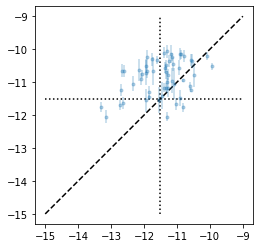

In [247]:
from utils import *
high_binder_cutoff=-5*np.log(10)



traning_RMSE={}
XVals_RMSE={}
XVals_Cor={}
XVals_KT={}
XVals_TPR={}

Val_RMSE={}
Val_Cor={}
Val_KT={}
Val_TPR={}


sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
# old_settings_folder=folder+"/meta_param_search/~settings/"
# sfiles = next(os.walk(old_settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory
for fn in tqdm(sfiles):
    settings_fname=settings_folder+"/"+fn
#     settings_fname=old_settings_folder+"/"+fn
    with open(settings_fname, 'rb') as f:
        metrics=None
        try:
            settings_loaded, metrics = pickle.load(f)
        except Exception:
            print(f"problem with {fn}")
        if(metrics is not None):
            if(settings_loaded[5]!=10):
                continue
#                 key=settings_loaded[1]
            key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}"
            if(key!="no_core_2D_3D_no_core_MDenerg_no_core_atom_hot_hlw10"):
                continue
            bi=np.argmin(metrics.loss_XVal)
            #bi=-1

            XVals_RMSE[key]=metrics.RMSD_XVal[bi]
            traning_RMSE[key]=metrics.RMSD_Train[bi]
            XVals_Cor[key]=metrics.Cor_XVal[bi]
            XVals_KT[key]=metrics.kendalltau_XVal[bi]
            XVals_TPR[key]=metrics.TP_XVal[bi]

            # Find predictions for validation ligands
            val_lig_P = metrics.best_pred[0][validation_ids_in_set4f]
            val_lig_uncert = metrics.best_pred[1][validation_ids_in_set4f]
            
            diag = np.linspace(-15,-9, 10)
            plt.plot(diag, diag, '--k', zorder=0)
            plt.vlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
            plt.hlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
            plt.errorbar(validation_dGs, val_lig_P, yerr=val_lig_uncert, marker=".", ls='', alpha=0.3)
            plt.gca().set_aspect('equal', 'box')
            
            # compute metrics for validation ligands
            se = np.square(validation_dGs-val_lig_P)
            Val_RMSE[key] = np.sqrt(np.mean(se))
            Val_Cor[key] = np.corrcoef(validation_dGs, val_lig_P)[0,1]
            Val_KT[key] = sp.stats.kendalltau(validation_dGs, val_lig_P)[0]
            _,Val_TPR[key],_ = get_FPR_TPR_AUC(validation_dGs, val_lig_P, high_binder_cutoff)
#             raise()



In [79]:
sorted_scan=dict(sorted(XVals_RMSE.items(), key=lambda item: item[1]))
#print(sorted_scan)
#print(list(sorted_scan.keys())[0])
#print(sorted_scan[list(sorted_scan.keys())[0]])

sorted_keys=list(sorted_scan.keys())
#print(f"{'REPRESENTATION':^40}\t{'XVal RMSE':^10}\t{'Train RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}")
print(f"{'REPRESENTATION':^40}\t{'XVal RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}")
#for i in range(min(10,len(sorted_scan))):
for i in range(len(sorted_scan)):
    key=sorted_keys[i]
    #if('hlw10' in key):
    #print(f"{key:40}\t{XVals_RMSE[key]:.4f}\t\t{traning_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")
    print(f"{key:40}\t{XVals_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")

             REPRESENTATION             	XVal RMSE 	 XVal Cor 	XVal Ken.-t	 XVal TPR 
2D_3D_PLEC_filtered_hlw10               	1.7452		0.5758		0.4122		0.8486
no_core_2D_3D_no_core_PLEC_filtered_no_core_MDenerg_no_core_atom_hot_hlw10	1.8892		0.5326		0.3827		0.7697
no_core_2D_3D_no_core_MDenerg_no_core_atom_hot_hlw10	1.9089		0.5207		0.3793		0.7792
2D_3D_PLEC_filtered_MDenerg_atom_hot_hlw10	1.9120		0.5369		0.3790		0.7792
2D_3D_PLEC_filtered_atom_hot_hlw10      	1.9328		0.4709		0.3309		0.8107
no_core_2D_3D_no_core_PLEC_filtered_no_core_atom_hot_hlw10	1.9444		0.5268		0.3757		0.7760
2D_3D_atom_hot_hlw10                    	1.9857		0.4833		0.3391		0.7886
2D_3D_PLEC_filtered_MDenerg_hlw10       	1.9904		0.5125		0.3893		0.7950
no_core_2D_3D_no_core_atom_hot_hlw10    	2.0469		0.4561		0.3424		0.7445
2D_3D_MDenerg_atom_hot_hlw10            	2.1173		0.4891		0.3621		0.7508
2D_3D_MDenerg_hlw10                     	2.1937		0.4638		0.3706		0.8044
PLEC_filtered_MDenerg_atom_hot_hlw10    	2.3259		0.3264	

In [ ]:
# replace nans with high numbers


## rank by the 4 indicators

In [80]:
sorted_RMSE=dict(sorted(XVals_RMSE.items(), key=lambda item: item[1]))
sorted_Cor= dict(sorted(XVals_Cor.items(), key=lambda item: item[1]))
sorted_KT=  dict(sorted(XVals_KT.items(), key=lambda item: item[1]))
sorted_TPR= dict(sorted(XVals_TPR.items(), key=lambda item: item[1]))

#RMSE
# rank_RMSE={}
# keys=list(sorted_RMSE.keys())
# start_key=keys[0]
# cur_rank=0
# for i in range(len(sorted_RMSE)):
#     key=keys[i]
#     dif=abs(XVals_RMSE[key]-XVals_RMSE[start_key])
#     err=np.sqrt(traning_RMSE[key]**2+traning_RMSE[start_key]**2)
#     if(dif>err):
#         #new rank
#         cur_rank+=1
#         start_key=key
#     rank_RMSE[key]=cur_rank

from sklearn.cluster import KMeans
nranks=5
#def rank_by_kmeans(d, nranks=10):
def rank_by_kmeans(d, nranks=nranks):
    X = np.array([[v[1]] for v in d.items()])
    kmeans = KMeans(n_clusters=nranks, random_state=0).fit(X)
    sorted_cl_ids=np.argsort(kmeans.cluster_centers_.flatten())
    #print(kmeans.cluster_centers_[sorted_cl_ids])
    rank_from_cl_id={}
    for i,j in enumerate(sorted_cl_ids):
        rank_from_cl_id[j]=i
    
    ret={}
    for i,key in enumerate(d.keys()):
        ret[key]=rank_from_cl_id[kmeans.labels_[i]]
    return(ret)

rank_RMSE=rank_by_kmeans(sorted_RMSE)
rank_Cor=rank_by_kmeans(sorted_Cor)
rank_KT=rank_by_kmeans(sorted_KT)
rank_TPR=rank_by_kmeans(sorted_TPR)


rank={}
for key in rank_RMSE.keys():
    rank[key]=rank_RMSE[key]+(nranks-1-rank_Cor[key])+(nranks-1-rank_KT[key])+(nranks-1-rank_TPR[key])

sorted_rank= dict(sorted(rank.items(), key=lambda item: item[1]))
keys=list(sorted_rank.keys())

#print(f"{'RANK':^4}\t{'REPRESENTATION':^40}\t{'XVal RMSE':^10}\t{'Train RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}")
print(f"{'RANK':^4}\t{'REPRESENTATION':^40}\t{'XVal RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}\t|\t{'Val RMSE':^10}\t{'Val Cor':^10}\t{'Val Ken.-t':^10}\t{'Val TPR':^10}")
for i in range(len(sorted_RMSE)):
    key=keys[i]
    #print(f"{rank[key]:4}\t{key:40}\t{XVals_RMSE[key]:.4f}\t\t{traning_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")
    #print(f"{rank[key]:4}\t{key:40}\t{XVals_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")
    r=rank[key]
    print(f"{r:4}\t{key:40}\t{XVals_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}\t\t"+
          f"|\t{Val_RMSE[key]:.4f}\t\t{Val_Cor[key]:.4f}\t\t{Val_KT[key]:.4f}\t\t{Val_TPR[key]:.4f}")

RANK	             REPRESENTATION             	XVal RMSE 	 XVal Cor 	XVal Ken.-t	 XVal TPR 	|	 Val RMSE 	 Val Cor  	Val Ken.-t	 Val TPR  
   0	2D_3D_PLEC_filtered_hlw10               	1.7452		0.5758		0.4122		0.8486		|	1.0272		0.3073		0.3101		0.1364
   1	2D_3D_PLEC_filtered_MDenerg_hlw10       	1.9904		0.5125		0.3893		0.7950		|	0.8109		0.3208		0.2508		0.3636
   2	no_core_2D_3D_no_core_PLEC_filtered_no_core_MDenerg_no_core_atom_hot_hlw10	1.8892		0.5326		0.3827		0.7697		|	0.9955		0.0405		0.0108		0.0000
   2	no_core_2D_3D_no_core_MDenerg_no_core_atom_hot_hlw10	1.9089		0.5207		0.3793		0.7792		|	0.9541		0.3659		0.2063		0.2727
   2	2D_3D_PLEC_filtered_MDenerg_atom_hot_hlw10	1.9120		0.5369		0.3790		0.7792		|	1.1907		0.1132		0.0917		0.0000
   2	no_core_2D_3D_no_core_PLEC_filtered_no_core_atom_hot_hlw10	1.9444		0.5268		0.3757		0.7760		|	1.1882		0.2613		0.1146		0.0909
   3	2D_3D_PLEC_filtered_atom_hot_hlw10      	1.9328		0.4709		0.3309		0.8107		|	1.1642		0.1539		0.0526		0.1818
   3	2D_3D_atom_hot_

# try different levels of importance filtering for feature selection
on 2D_3D_PLEC_filtered_MDenerg_atom_hot_hlw10

### build the filters

In [204]:
#read settings from unfiltered run
#old_fname=settings_folder+"/2D_3D_PLEC_filtered_MDenerg_atom_hot_99f93dc3e6.pickle"
old_fname=settings_folder+"/2D_3D_PLEC_filtered_6806b88a1e.pickle"
with open(old_fname, 'rb') as f:
    settings_loaded, metrics = pickle.load(f)
    
representation_flags, dr_name, normalize_x, shuffle_seed, n_Epochs, hl_w, hl_depth,\
    init_learning_rate, learning_rate_decay, weight_decay, impfilt, X_filter, weighted, shiftY, use_dropout = settings_loaded

if(X_filter is not None):
    raise(Exception("X_filter should be None for reference run"))

with open(all_ligs_db_file, 'rb') as f:
    all_ligs = pickle.load(f)
training_ligs=[all_ligs[i] for i in range(len(all_ligs)) if all_ligs[i].HasProp("dG")]
del all_ligs
_=gc.collect()

training_dataset = CustomMolModularDataset(ligs=training_ligs, representation_flags=representation_flags, normalize_x=normalize_x, X_filter=X_filter)
print("Set up Training dataset", datetime.now())
if(normalize_x):
    # this should read the ones from the full dataset
    training_dataset.find_normalization_factors()

n_features = training_dataset[0][0].shape[-1]
print("# features before imp filtering:", n_features, datetime.now())
Gen = torch.utils.data.DataLoader(training_dataset,   shuffle=False, batch_size=len(training_ligs))

Set up Training dataset 2022-02-04 00:34:04.626554
# features before imp filtering: 2231 2022-02-04 00:37:40.635439


In [205]:
# detailed params
activation="relu"
high_binder_cutoff=-5*np.log(10)
weight_func=None # only needed for training
if(use_dropout):
    p_dropout=np.repeat(0.5, hl_depth+1)
else:
    p_dropout=np.repeat(0.0, hl_depth+1)
noise=0.0
XVal_blocks=5
device=torch.device("cpu")

sha = hashlib.sha256()
sha.update(pickle.dumps(settings_loaded))
settings_hash=sha.hexdigest()[:10]

# load models
save_folder=f"{pocket_fit_folder}/prediction_step_3/combined_repr_search/models/{dr_name}/"
save_folder+=f"known_{len(training_ligs)}_width_{hl_w}_depth_{hl_depth}"+\
                f"_trd_{learning_rate_decay}_wd_{weight_decay}"+("" if impfilt is None else f"_impfilt_{impfilt}")+\
                ('' if not normalize_x else '_norm_X')+("" if not weighted else "_weightedbyY")+("" if not use_dropout else f"_dropout{p_dropout[0]}")+\
                ('' if noise<=0.0 else f"_noise_{noise}")+("_shiftY" if shiftY else "")+f"_{n_Epochs}ep"
model_folder=f"{save_folder}/training_models"
models=[]
for i_m in range(XVal_blocks):
    #create model
    m = Net(inp_width=n_features, hl_w=hl_w, nhl=hl_depth, activation=activation,
                learning_rate=init_learning_rate, lr_decay=learning_rate_decay,
                high_binder_cutoff=high_binder_cutoff, weight_decay=weight_decay,
                weights_distrib_func=weight_func, drop_p=p_dropout, noise=noise, shiftY=shiftY).to(device)
    # we will only use the best models, not the final ones
    m.load_state_dict(torch.load(model_folder+f"/model_{i_m}_{settings_hash}_best_so_far.ptmod"))
    models.append(m)
print("Loaded models", datetime.now())


from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

attrs=[]

for m in models:
    ig = IntegratedGradients(m)
    test_input_tensor=next(iter(Gen))[0]
    test_input_tensor.requires_grad_()
    attr, delta = ig.attribute(test_input_tensor,target=0, return_convergence_delta=True)
    attr = attr.detach().numpy()
    attrs.append(attr)
attrs=np.array(attrs)
print(attrs.shape)
attr=np.mean(np.abs(attrs), axis=0)
print(attr.shape)

importances=np.mean(np.abs(attr), axis=0)
print("max importance:", np.max(importances))

del attrs, models
_=gc.collect()

Loaded models 2022-02-04 00:37:41.119298
(5, 395, 2231)
(395, 2231)
max importance: 0.04310525876945448


filter_layers: [0, 0.01, 0.015, 0.02, 0.025, 0.03]
[1960, 1670, 951, 281, 77, 19]


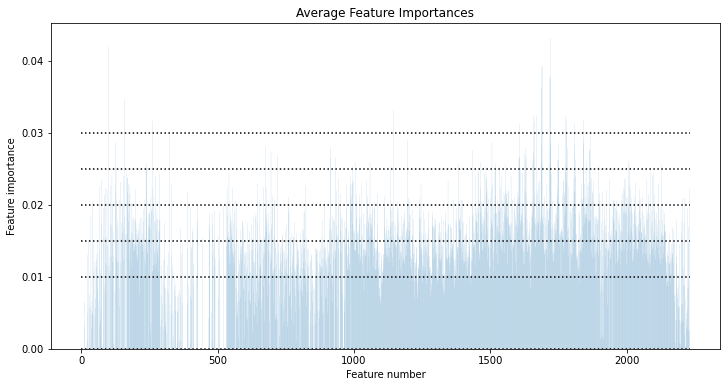

In [210]:
#filter_layers=[0, 0.0025, 0.005, 0.006, 0.0075, 0.009, 0.01, 0.0125, 0.015]
filter_layers=[0, 0.01, 0.015, 0.02, 0.025, 0.03]
print("filter_layers:", filter_layers)

filt_sizes=[]
for filt_imp in filter_layers:
    filt_sizes.append(len(importances[importances>filt_imp]))
    pickle.dump( np.where(importances>filt_imp)[0],
                open( f"{save_folder}/Xfilter_importance_over_{filt_imp}.pickle", "wb" ) )
print(filt_sizes)

def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.xlabel('Feature number')
        plt.ylabel('Feature importance')
        plt.bar(x_pos, importances, align='center', alpha=0.4, snap=False)
        for filt_imp in filter_layers:
            plt.hlines(filt_imp,0,len(feature_names),colors='k', linestyles='dotted')
        
        plt.title(title)
        plt.show()
visualize_importances( np.arange(attr.shape[1]), importances)

### build settings files for each filter

In [220]:
filter_scan_settings_folder=folder+"/combined_repr_search/filter_scan_settings/"
os.makedirs(filter_scan_settings_folder, exist_ok=True)

#read settings from unfiltered run
#old_fname=settings_folder+"/2D_3D_PLEC_filtered_MDenerg_atom_hot_99f93dc3e6.pickle"
#filter_layers=[0, 0.0025, 0.005, 0.006, 0.0075, 0.009, 0.01, 0.0125, 0.015]
old_fname=settings_folder+"/2D_3D_PLEC_filtered_6806b88a1e.pickle"
filter_layers=[0, 0.01, 0.015, 0.02, 0.025, 0.03]
with open(old_fname, 'rb') as f:
    settings_loaded, metrics = pickle.load(f)
    
settings=settings_loaded

#hiddeln_layer_widths=[10,20,50,100,200,300]
hidden_layer_widths=[10,100,200,300]
#hidden_layer_widths=[10]

# overwrite filter
for hlw in hidden_layer_widths:
    for filt_imp in filter_layers:
        settings[10]=filt_imp
        settings[11]=f"{save_folder}/Xfilter_importance_over_{filt_imp}.pickle"
        settings[5]=hlw

        sha = hashlib.sha256()
        sha.update(pickle.dumps(settings))
        settings_hash=dr_name+"_"+sha.hexdigest()[:10]

        settings_fname=filter_scan_settings_folder+f"{settings_hash}.pickle"
        if(os.path.exists(settings_fname)):
            with open(settings_fname, 'rb') as f:
                settings_loaded, metrics = pickle.load(f)
                if(metrics is not None and not redo):
                    print(f"{settings_fname} is already trained.")
                else:
                    print(f"{settings_fname} exists but is not trained yet.")
        else:
            pickle.dump( (settings, None), open( settings_fname, "wb" ) )
#         break;

/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_3//combined_repr_search/filter_scan_settings/2D_3D_PLEC_filtered_179df93923.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_3//combined_repr_search/filter_scan_settings/2D_3D_PLEC_filtered_94bd7c0061.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_3//combined_repr_search/filter_scan_settings/2D_3D_PLEC_filtered_d15168ac88.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_3//combined_repr_search/filter_scan_settings/2D_3D_PLEC_filtered_26dca6020a.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_su

### Try running training locally

In [222]:
if 'custom_dataset_modular_with_binning' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning'])
else:
    import custom_dataset_modular_with_binning
from custom_dataset_modular_with_binning import dataBlocks, CustomMolModularDataset

if 'owl_trainer_w_params_general' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_general'])
else:
    import owl_trainer_w_params_general
from owl_trainer_w_params_general import *

# if 'NNs' in sys.modules:
#     importlib.reload(sys.modules['NNs'])
# else:
#     import NNs
# from NNs import *


In [168]:
import queue
import threading

previously_done=0
max_debug_evals=10e8

sfiles = next(os.walk(filter_scan_settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

q = queue.Queue()
for f in tqdm(sfiles):
    settings_fname=filter_scan_settings_folder+"/"+f
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        if(metrics is None):
            q.put(settings_fname)
            #print(settings_fname)
            if(q.qsize()>=max_debug_evals):
                break;
        else:
            previously_done+=1

print("previously_done:", previously_done, "\t out of:", len(sfiles), flush=True)
nleft=len(sfiles)-previously_done
nworkers=max(min(30, nleft), 1)
n_per_worker=int(np.ceil(float(nleft)/nworkers))
print("settings left:", nleft, "\t # workers:", nworkers, "\t # settings/worker:", n_per_worker)

# raise()

cwd=folder+"/meta_param_search/local_runs/"
cmd_str=f"source /etc/profile; module load sge; cd {cwd};"
cmd_str_SLURM=f"source /etc/profile; cd {cwd};"

def worker(job_id):
    ligands_str=""
    for l in range(n_per_worker):
        fname = q.get()
        if fname is None:  # EOF?
            break
        ligands_str+=" "+fname
    os.makedirs(cwd, exist_ok=True)


    train_model_with_settings_general(ligands_str[1:], False,
                                      torch.device("cpu"), #torch.device("cuda:0"),
                                      True,
                                      #datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0",
                                      datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_3/combined_repr_search",
                                      save_folder_base=f"{pocket_fit_folder}/prediction_step_3/combined_repr_search",
                                      all_ligs_db_file=all_ligs_db_file,
                                      all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step3_dG.pickle",
                                      predict_all_ligs=False
                                     )
    raise()

for job_id in range(nworkers):
    q.put(None)
    worker(job_id)

print("Done.")

100%|██████████| 9/9 [00:00<00:00, 12599.71it/s]

previously_done: 0 	 out of: 9
settings left: 9 	 # workers: 9 	 # settings/worker: 1




Representation is: 2D_3D_PLEC_filtered_MDenerg_atom_hot


Read ligands 2022-02-03 23:41:32.554249
# of training ligands found: 395 2022-02-03 23:41:32.587926
# starting ligands: 395 2022-02-03 23:41:32.732782
Finished setting up weights 2022-02-03 23:41:32.734172
Building the internal_filtered_cache needs 1054.3503875732422 MB, more than the 0.0 MB limit. SKIPPING and will read samples from HDD each time instead.
Found normalization factors across all ligands 2022-02-03 23:41:39.740912
Start setting up models 2022-02-03 23:41:39.742010
There are 4050 features 2022-02-03 23:41:39.876848
Finished setup for model 0 2022-02-03 23:41:40.183855
Finished setup for model 1 2022-02-03 23:41:40.486173
Finished setup for model 2 2022-02-03 23:41:40.785750
Finished setup for model 3 2022-02-03 23:41:41.082372
Finished setup for model 4 2022-02-03 23:41:41.377737
Training for 20000 epochs 2022-02-03 23:41:41.377850
	Epoch: 0	 train_loss=7.953960514068603	 XVal_RMSE=13.518216133117676
	Epoch: 9	 train_loss=2.1943392038345335	 XVal_RMSE=4.178399562835693
	E

KeyboardInterrupt: 

### Submit training to moa

In [221]:
import queue
import threading

previously_done=0
max_debug_evals=10e8
# max_debug_evals=1

sfiles = next(os.walk(filter_scan_settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

q = queue.Queue()
for f in tqdm(sfiles):
    settings_fname=filter_scan_settings_folder+"/"+f
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        if(metrics is None):
            q.put(settings_fname)
            #print(settings_fname)
            if(q.qsize()>=max_debug_evals):
                break;
        else:
            previously_done+=1

print("previously_done:", previously_done, "\t out of:", len(sfiles), flush=True)
print("will run:", q.qsize())
nleft=min(len(sfiles)-previously_done, q.qsize())
nworkers=max(min(30, nleft), 1)
n_per_worker=int(np.ceil(float(nleft)/nworkers))
print("settings left:", nleft, "\t # workers:", nworkers, "\t # settings/worker:", n_per_worker)

# raise()

cwd=f"{pocket_fit_folder}/prediction_step_3/combined_repr_search/jobscripts/"
cmd_str=f"source /etc/profile; module load sge; cd {cwd};"
cmd_str_SLURM=f"source /etc/profile; cd {cwd};"

def worker(job_id):
#     if(job_id==0):
#         return();
    ligands_str=""
    for l in range(n_per_worker):
        fname = q.get()
        if fname is None:  # EOF?
            break
        ligands_str+=" "+fname
    os.makedirs(cwd, exist_ok=True)
    jobscript_str=f"""#!/bin/bash
    
#$ -S /bin/bash
#$ -pe openmp_fast 10
#$ -q *
#$ -N pytorch_GPU_worker_{job_id}
#$ -M ykhalak@gwdg.de
#$ -m n
#$ -l h_rt=5:00:00
#$ -wd {cwd}

#SBATCH --job-name=pytorch_SLURM_GPU_worker_{job_id}
#SBATCH --get-user-env
#SBATCH --gres=gpu:1              # number of GPUs requested
#SBATCH --ntasks=1                # Number of MPI process
#SBATCH --cpus-per-task=10        # CPU cores per MPI process
##SBATCH -p p24,p20,p16,p10,p08,p06    # partitions to use
#SBATCH -p p10,p08,p06            # partitions to use
#SBATCH -t 5:00:0                 # hours:min:sec
#SBATCH --chdir={cwd}
#SBATCH -e repr_scan_{job_id}-%j.err
#SBATCH -o repr_scan_{job_id}-%j.out
#SBATCH --mem=4000

if [ -n "$NHOSTS" ]; then
    echo "Env. variable NHOSTS found, assuming we are using SGE."
    module load shared                           # access to modules in /cm/shared
else
    echo "Env. variable NHOSTS not set, assuming we are using SLURM."
    export NHOSTS=$SLURM_JOB_NUM_NODES
    export NSLOTS=$SLURM_CPUS_PER_TASK
fi

echo NHOSTS=$NHOSTS
echo NSLOTS=$NSLOTS
echo TMPDIR=$TMPDIR
hostname

echo "#################################################"

export OMP_NUM_THREADS=$NSLOTS
export MKL_NUM_THREADS=$NSLOTS

source ~/.ML_v2_profile
#source ~/.ML_v2_on_energy_profile

cp /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_3/combined_repr_search/deployable_training_data.tar.gz $TMPDIR/.
cd $TMPDIR
tar -zxf deployable_training_data.tar.gz
cd {cwd}

echo "Done extracting data"

python /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/owl_trainer_w_params_general.py -v -f {ligands_str} --datafolder $TMPDIR --save_folder_base {pocket_fit_folder}/prediction_step_3/combined_repr_search --ligsf {all_ligs_db_file_energy} --nocoref {all_no_core_ligs_db_file_energy} --no_pred

"""
    jobscript_fn=cwd+"/jobscript_{}".format(job_id)
    with open(jobscript_fn,"w") as f:
        f.write(jobscript_str)

    global cmd_str, cmd_str_SLURM
    cmd_str+=" qsub {};".format(jobscript_fn)
    cmd_str_SLURM+=" sbatch {};".format(jobscript_fn)

for job_id in range(nworkers):
    q.put(None)
    worker(job_id)    
    
# raise()

print("Submitting.")
# ssh_cmd_arr=["ssh", "owl", cmd_str]
ssh_cmd_arr=["ssh", "moa2", cmd_str_SLURM]
process = subprocess.Popen(ssh_cmd_arr, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
outs, _ = process.communicate()
process.wait()
print('== subprocess exited with rc =', process.returncode)
print(outs.decode('utf-8'))
print("Done.")

100%|██████████| 42/42 [00:00<00:00, 140.16it/s]

previously_done: 30 	 out of: 42


will run: 12
settings left: 12 	 # workers: 12 	 # settings/worker: 1
Submitting.
== subprocess exited with rc = 0
Submitted batch job 490885
Submitted batch job 490886
Submitted batch job 490887
Submitted batch job 490888
Submitted batch job 490889
Submitted batch job 490890
Submitted batch job 490891
Submitted batch job 490892
Submitted batch job 490893
Submitted batch job 490894
Submitted batch job 490895
Submitted batch job 490896

Done.


### do predictions locally

In [241]:
import queue
import threading

from datetime import datetime
import hashlib

previously_done=0
max_debug_evals=10e8

sfiles = next(os.walk(filter_scan_settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0"

n_not_ready=0
q = queue.Queue()
for f in tqdm(sfiles):
    settings_fname=filter_scan_settings_folder+"/"+f
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        
#         key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}_impfilt{settings_loaded[10]}"
#         if(key =="2D_3D_PLEC_filtered_hlw300_impfilt0.02"):
#             print(f)
#             raise()
#         else:
#             continue
        
        if(metrics is None):
            n_not_ready+=1
            continue
        if(metrics.best_pred is None or metrics.final_pred is None):
            q.put(settings_fname)
            #print(settings_fname)
            if(q.qsize()>=max_debug_evals):
                break;
        else:
            previously_done+=1

print("previously_done:", previously_done, "\tnot ready:", n_not_ready, "\t out of:", len(sfiles), flush=True)
nleft=min(len(sfiles)-previously_done, q.qsize())
nworkers=max(min(30, nleft), 1)
n_per_worker=int(np.ceil(float(nleft)/nworkers))
print("settings left:", nleft, "\t # workers:", nworkers, "\t # settings/worker:", n_per_worker)

# raise()

def worker(job_id):
    for l in range(n_per_worker):
        fname = q.get()
        if fname is None:  # EOF?
            break

        Predict_from_saved_models(fname, False,
                              torch.device("cpu"), #torch.device("cuda:0"),
                              True, datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0",
                              save_folder_base=f"{pocket_fit_folder}/prediction_step_3/combined_repr_search",
                              all_ligs_db_file=all_ligs_db_file,
                              all_no_core_ligs_db_file=all_no_core_ligs_db_file,
                              max_cache_Mem_MB=1024*6
                             )

#     raise()

for job_id in range(nworkers):
    q.put(None)
    worker(job_id)

print("Done.")

100%|██████████| 42/42 [00:00<00:00, 91.04it/s]

previously_done: 9 	not ready: 0 	 out of: 42
settings left: 33 	 # workers: 30 	 # settings/worker: 2
Representation is: 2D_3D_PLEC_filtered_MDenerg_atom_hot 2022-02-04 11:17:32.693742


Found normalization factors across all ligands 2022-02-04 11:18:40.705819
Loaded models 2022-02-04 11:18:41.506976
Finished predictions 2022-02-04 11:18:46.516786
Representation is: 2D_3D_PLEC_filtered_MDenerg_atom_hot 2022-02-04 11:18:48.359514
Found normalization factors across all ligands 2022-02-04 11:19:40.158888
Loaded models 2022-02-04 11:19:40.527626
Finished predictions 2022-02-04 11:19:44.434623
Representation is: 2D_3D_PLEC_filtered_MDenerg_atom_hot 2022-02-04 11:19:46.314647
Found normalization factors across all ligands 2022-02-04 11:20:00.372797
Loaded models 2022-02-04 11:20:01.194572
Finished predictions 2022-02-04 11:20:04.680420
Representation is: 2D_3D_PLEC_filtered_MDenerg_atom_hot 2022-02-04 11:20:06.558378
Found normalization factors across all ligands 2022-02-04 11:20:19.636418
Loaded models 2022-02-04 11:20:19.921967
Finished predictions 2022-02-04 11:20:23.576114
Representation is: 2D_3D_PLEC_filtered_MDenerg_atom_hot 2022-02-04 11:20:25.485894
Found normalizat

### What is the best filter, and hlw?

100%|██████████| 42/42 [00:02<00:00, 20.25it/s]


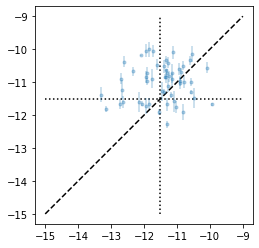

In [245]:
from utils import *
high_binder_cutoff=-5*np.log(10)



traning_RMSE={}
XVals_RMSE={}
XVals_Cor={}
XVals_KT={}
XVals_TPR={}

Val_RMSE={}
Val_Cor={}
Val_KT={}
Val_TPR={}


sfiles = next(os.walk(filter_scan_settings_folder), (None, None, []))[2]  # [] if no file
# old_settings_folder=folder+"/meta_param_search/~settings/"
# sfiles = next(os.walk(old_settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory
for fn in tqdm(sfiles):
    settings_fname=filter_scan_settings_folder+"/"+fn
#     settings_fname=old_settings_folder+"/"+fn
    with open(settings_fname, 'rb') as f:
        metrics=None
        try:
            settings_loaded, metrics = pickle.load(f)
        except Exception:
            print(f"problem with {fn}")
        if(metrics is not None):
#             if(settings_loaded[5]!=10):
#                 continue
#                 key=settings_loaded[1]
            key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}_impfilt{settings_loaded[10]}"
#             if(key!="2D_3D_PLEC_filtered_hlw300_impfilt0.02"):
#                 continue
            #key=f"hlw{settings_loaded[5]}_impfilt{settings_loaded[10]}"
            bi=np.argmin(metrics.loss_XVal)
            #bi=-1

            XVals_RMSE[key]=metrics.RMSD_XVal[bi]
            traning_RMSE[key]=metrics.RMSD_Train[bi]
            XVals_Cor[key]=metrics.Cor_XVal[bi]
            XVals_KT[key]=metrics.kendalltau_XVal[bi]
            XVals_TPR[key]=metrics.TP_XVal[bi]

            # Find predictions for validation ligands
            if(metrics.best_pred is not None):
                val_lig_P = metrics.best_pred[0][validation_ids_in_set4f]
                val_lig_uncert = metrics.best_pred[1][validation_ids_in_set4f]

                diag = np.linspace(-15,-9, 10)
                plt.plot(diag, diag, '--k', zorder=0)
                plt.vlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
                plt.hlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
                plt.errorbar(validation_dGs, val_lig_P, yerr=val_lig_uncert, marker=".", ls='', alpha=0.3)
                plt.gca().set_aspect('equal', 'box')

                # compute metrics for validation ligands
                se = np.square(validation_dGs-val_lig_P)
                Val_RMSE[key] = np.sqrt(np.mean(se))
                Val_Cor[key] = np.corrcoef(validation_dGs, val_lig_P)[0,1]
                Val_KT[key] = sp.stats.kendalltau(validation_dGs, val_lig_P)[0]
                _,Val_TPR[key],_ = get_FPR_TPR_AUC(validation_dGs, val_lig_P, high_binder_cutoff)
#             raise()



In [243]:
sorted_scan=dict(sorted(XVals_RMSE.items(), key=lambda item: item[1]))

sorted_keys=list(sorted_scan.keys())
print(f"{'REPRESENTATION':^60}\t{'XVal RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}")
for i in range(len(sorted_scan)):
    key=sorted_keys[i]
    #if('hlw10' in key):
    print(f"{key:60}\t{XVals_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")

                       REPRESENTATION                       	XVal RMSE 	 XVal Cor 	XVal Ken.-t	 XVal TPR 
2D_3D_PLEC_filtered_hlw300_impfilt0.02                      	1.4254		0.6660		0.4762		0.9432
2D_3D_PLEC_filtered_hlw100_impfilt0.015                     	1.4991		0.6292		0.4519		0.9274
2D_3D_PLEC_filtered_hlw200_impfilt0.02                      	1.5185		0.6296		0.4581		0.9369
2D_3D_PLEC_filtered_hlw300_impfilt0.015                     	1.5234		0.6134		0.4485		0.9464
2D_3D_PLEC_filtered_hlw200_impfilt0.025                     	1.5617		0.6230		0.4567		0.9338
2D_3D_PLEC_filtered_hlw100_impfilt0.01                      	1.5811		0.5831		0.4134		0.9211
2D_3D_PLEC_filtered_hlw100_impfilt0.02                      	1.5842		0.6145		0.4403		0.9180
2D_3D_PLEC_filtered_hlw200_impfilt0.03                      	1.5854		0.6700		0.4792		0.8202
2D_3D_PLEC_filtered_hlw200_impfilt0.01                      	1.6082		0.5502		0.3970		0.9495
2D_3D_PLEC_filtered_hlw300_impfilt0.025                     	1.609

In [244]:
sorted_RMSE=dict(sorted(XVals_RMSE.items(), key=lambda item: item[1]))
sorted_Cor= dict(sorted(XVals_Cor.items(), key=lambda item: item[1]))
sorted_KT=  dict(sorted(XVals_KT.items(), key=lambda item: item[1]))
sorted_TPR= dict(sorted(XVals_TPR.items(), key=lambda item: item[1]))

#RMSE
# rank_RMSE={}
# keys=list(sorted_RMSE.keys())
# start_key=keys[0]
# cur_rank=0
# for i in range(len(sorted_RMSE)):
#     key=keys[i]
#     dif=abs(XVals_RMSE[key]-XVals_RMSE[start_key])
#     err=np.sqrt(traning_RMSE[key]**2+traning_RMSE[start_key]**2)
#     if(dif>err):
#         #new rank
#         cur_rank+=1
#         start_key=key
#     rank_RMSE[key]=cur_rank

from sklearn.cluster import KMeans
nranks=5
#def rank_by_kmeans(d, nranks=10):
def rank_by_kmeans(d, nranks=nranks):
    X = np.array([[v[1]] for v in d.items()])
    kmeans = KMeans(n_clusters=nranks, random_state=0).fit(X)
    sorted_cl_ids=np.argsort(kmeans.cluster_centers_.flatten())
    #print(kmeans.cluster_centers_[sorted_cl_ids])
    rank_from_cl_id={}
    for i,j in enumerate(sorted_cl_ids):
        rank_from_cl_id[j]=i
    
    ret={}
    for i,key in enumerate(d.keys()):
        ret[key]=rank_from_cl_id[kmeans.labels_[i]]
    return(ret)

rank_RMSE=rank_by_kmeans(sorted_RMSE)
rank_Cor=rank_by_kmeans(sorted_Cor)
rank_KT=rank_by_kmeans(sorted_KT)
rank_TPR=rank_by_kmeans(sorted_TPR)


rank={}
for key in rank_RMSE.keys():
    rank[key]=rank_RMSE[key]+(nranks-1-rank_Cor[key])+(nranks-1-rank_KT[key])+(nranks-1-rank_TPR[key])

sorted_rank= dict(sorted(rank.items(), key=lambda item: item[1]))
keys=list(sorted_rank.keys())

#print(f"{'RANK':^4}\t{'REPRESENTATION':^40}\t{'XVal RMSE':^10}\t{'Train RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}")
print(f"{'RANK':^4}\t{'REPRESENTATION':^60}\t{'XVal RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}\t|\t{'Val RMSE':^10}\t{'Val Cor':^10}\t{'Val Ken.-t':^10}\t{'Val TPR':^10}")
for i in range(len(sorted_RMSE)):
    key=keys[i]
    #print(f"{rank[key]:4}\t{key:40}\t{XVals_RMSE[key]:.4f}\t\t{traning_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")
    #print(f"{rank[key]:4}\t{key:40}\t{XVals_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")
    r=rank[key]
    if(key in Val_RMSE):
        print(f"{r:4}\t{key:60}\t{XVals_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}\t\t"+
          f"|\t{Val_RMSE[key]:.4f}\t\t{Val_Cor[key]:.4f}\t\t{Val_KT[key]:.4f}\t\t{Val_TPR[key]:.4f}")
    else:
        print(f"{r:4}\t{key:60}\t{XVals_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}\t\t")

RANK	                       REPRESENTATION                       	XVal RMSE 	 XVal Cor 	XVal Ken.-t	 XVal TPR 	|	 Val RMSE 	 Val Cor  	Val Ken.-t	 Val TPR  
   0	2D_3D_PLEC_filtered_hlw300_impfilt0.02                      	1.4254		0.6660		0.4762		0.9432		|	0.9964		0.1110		0.0364		0.3636
   0	2D_3D_PLEC_filtered_hlw200_impfilt0.02                      	1.5185		0.6296		0.4581		0.9369		|	0.9419		0.0991		0.0526		0.3182
   0	2D_3D_PLEC_filtered_hlw300_impfilt0.015                     	1.5234		0.6134		0.4485		0.9464		|	0.8599		0.2038		0.1011		0.3636
   1	2D_3D_PLEC_filtered_hlw100_impfilt0.015                     	1.4991		0.6292		0.4519		0.9274		|	0.8675		0.1486		0.0458		0.3182
   1	2D_3D_PLEC_filtered_hlw200_impfilt0.025                     	1.5617		0.6230		0.4567		0.9338		|	1.0626		0.2155		0.1699		0.2273
   1	2D_3D_PLEC_filtered_hlw100_impfilt0.02                      	1.5842		0.6145		0.4403		0.9180		|	1.0608		0.1076		0.0553		0.1818
   2	2D_3D_PLEC_filtered_hlw300_impfilt0.025             

# Select step_4 ligands
Use 2D_3D_PLEC_filtered_hlw300_impfilt0 <br>
hlw=300, depth=2, importance limit=0.02 (281 features)
<pre>
RANK	                       REPRESENTATION                       	XVal RMSE 	 XVal Cor 	XVal Ken.-t	 XVal TPR 	|	 Val RMSE 	 Val Cor  	Val Ken.-t	 Val TPR  
   0	2D_3D_PLEC_filtered_hlw300_impfilt0.02                      	1.4254		0.6660		0.4762		0.9432	
</pre>

In [ ]:
# best_keys=['2D_3D_hlw10', '', 'no_core_2D_3D_hlw10', 'atom_hot_hlw10', 'no_core_atom_hot_hlw10', 'MDenerg_long_cut_binned_hlw10']
# print(best_keys)

In [2]:
# sfiles = next(os.walk(filter_scan_settings_folder), (None, None, []))[2]  # [] if no file
# sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory
sfiles=["2D_3D_PLEC_filtered_d0d5b7ebff.pickle"]
new_lig_ids=[]
for fn in tqdm(sfiles):
    settings_fname=filter_scan_settings_folder+"/"+fn
    with open(settings_fname, 'rb') as f:
        metrics=None
        try:
            settings_loaded, metrics = pickle.load(f)
        except Exception:
            print(f"problem with {fn}")
        if(metrics is not None):
            key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}_impfilt{settings_loaded[10]}"
#             if(key in best_keys):
            print(key)
            unmeasured_P = metrics.best_pred[0][unmeasured_ids_in_set4f]
            unmeasured_uncert = metrics.best_pred[1][unmeasured_ids_in_set4f]

            sorted_unmeasured_ids=unmeasured_ids_in_set4f[np.argsort(unmeasured_P)]
#                 print(metrics.best_pred[0][sorted_unmeasured_ids[:20]])
            selected=0
            n=0
            attempted_duplicates=0
            attempted_duplicates_by_repr=[0 for i in range(5)]
            while selected<100 and n<len(sorted_unmeasured_ids):
                if(sorted_unmeasured_ids[n] not in new_lig_ids):
                    new_lig_ids.append(sorted_unmeasured_ids[n])
                    selected+=1
                else:
                    attempted_duplicates+=1
                    prev_repr=int(np.floor(new_lig_ids.index(sorted_unmeasured_ids[n])/20))
                    attempted_duplicates_by_repr[prev_repr]+=1
                n+=1
            print(len(new_lig_ids), attempted_duplicates, attempted_duplicates_by_repr)
#                 raise()


NameError: name 'tqdm' is not defined

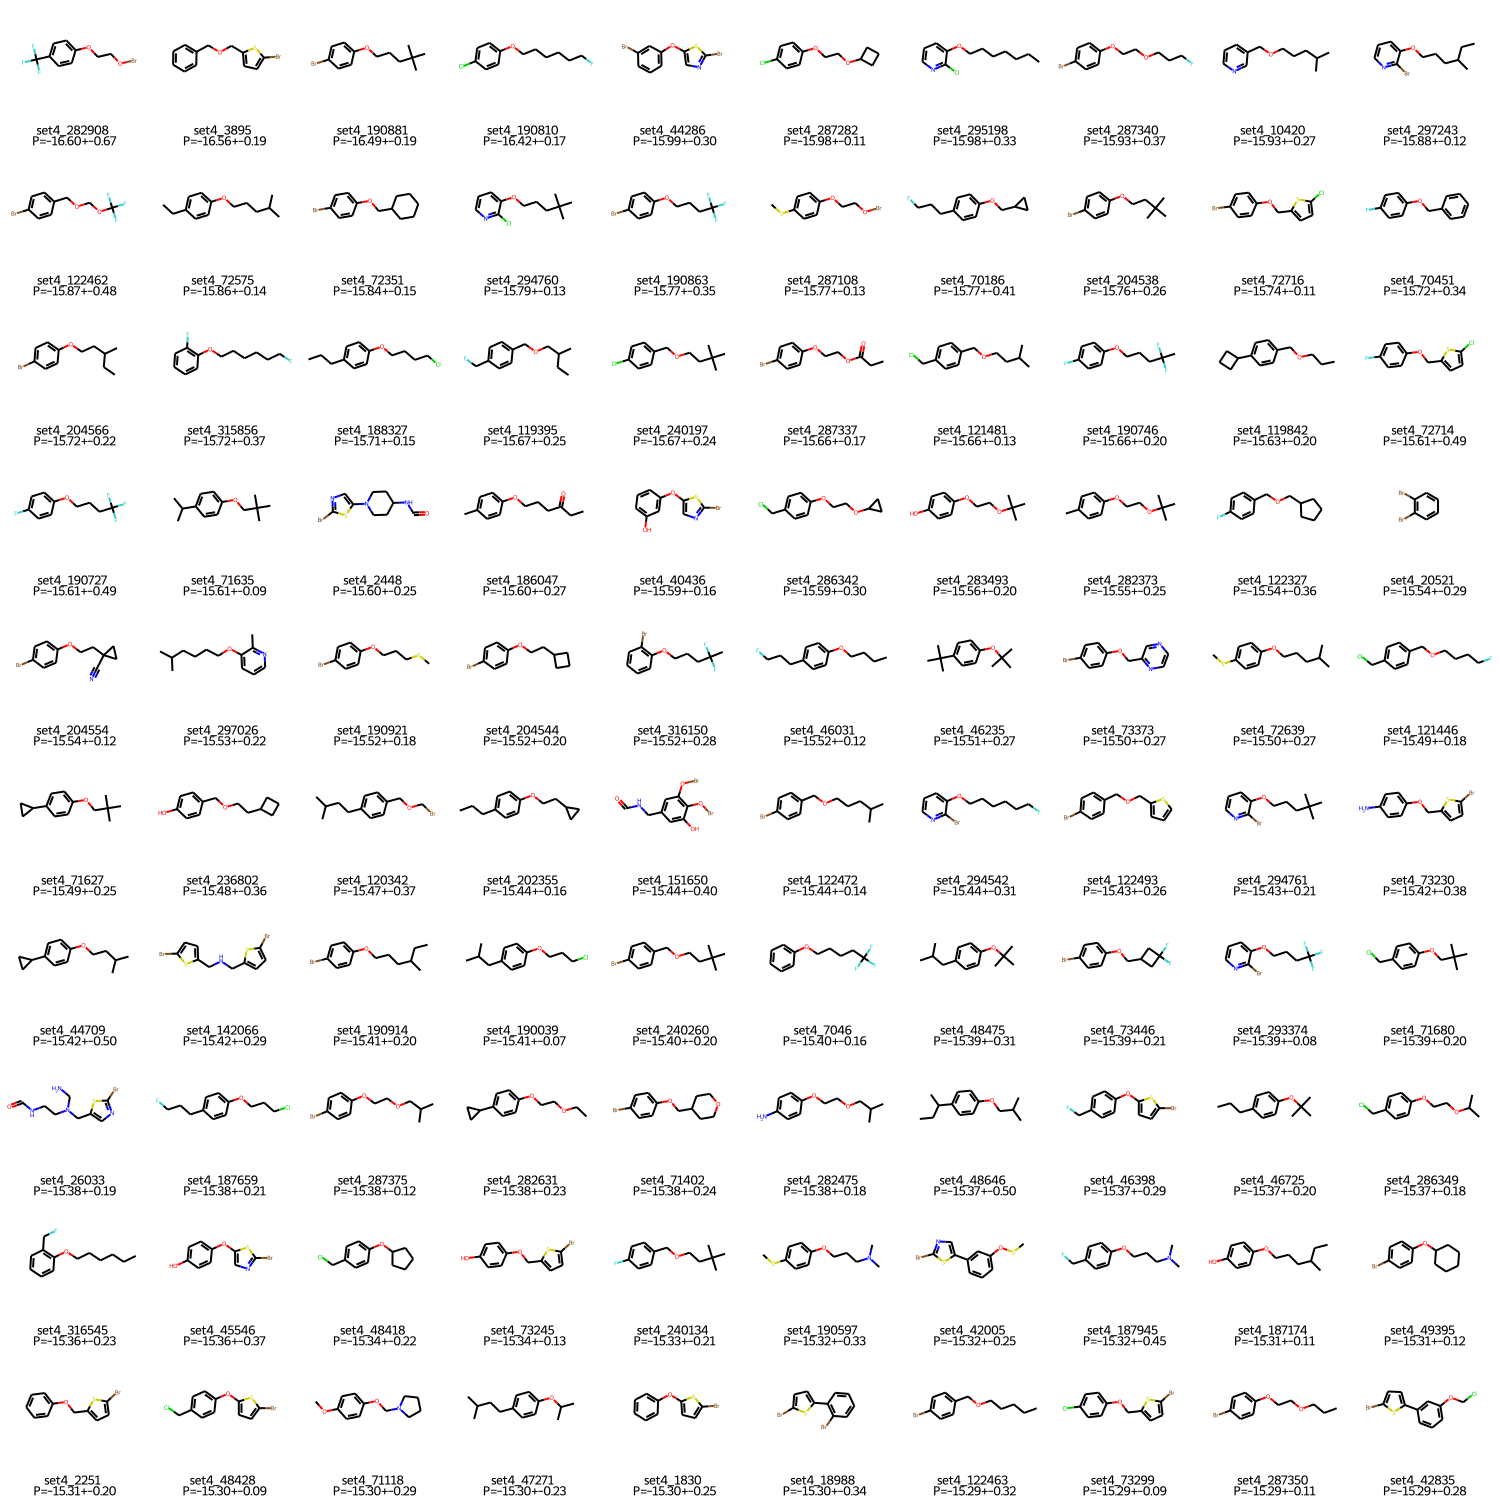

In [235]:
# all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step3_dG.pickle"
# all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step3_dG.pickle"

with open(all_ligs_db_file, 'rb') as f:
    ligs_set4f = pickle.load(f)
    
with open(all_no_core_ligs_db_file, 'rb') as f:
    no_core_ligs_set4f = pickle.load(f)


selected_ligs=[ligs_set4f[i] for i in new_lig_ids]
#legends=[f"{l.GetProp('ID')}" for l in selected_ligs]
metrics.best_pred[0]
legends=[f"{ligs_set4f[i].GetProp('ID')}\n P={metrics.best_pred[0][i]:.2f}+-{metrics.best_pred[1][i]:.2f}" for i in new_lig_ids]

selected_RGroups=[Chem.MolFromSmiles(Chem.MolToSmiles(no_core_ligs_set4f[i])) for i in new_lig_ids]
Draw.MolsToGridImage(selected_RGroups, legends=legends,
                     subImgSize = (150,150), molsPerRow=10, maxMols=100)


In [236]:
with open( pocket_fit_folder+"/step_4_picks.pickle", "wb" ) as f:
    pickle.dump(selected_ligs, f)

In [239]:
del ligs_set4f, no_core_ligs_set4f
_=gc.collect()

# Validation accuracy history so far

In [ ]:
from rdkit.Chem import rdmolops
validation_smiles=[Chem.MolToSmiles(rdmolops.RemoveHs(lig)) for lig in validation_ligs]

validation_ids_in_set4f=[]
validation_ids_in_validation_subset=[]
unmeasured_ids_in_set4f=[]
measured_ids_in_set4f=[]

#load only if not curretly loaded
try:
    ligs_set4f
except NameError:
    with open(all_ligs_db_file, 'rb') as f:
        ligs_set4f = pickle.load(f)

for i,lig in enumerate(tqdm(ligs_set4f)):
    smi=Chem.MolToSmiles(rdmolops.RemoveHs(lig))
    if(smi in validation_smiles):
        validation_ids_in_set4f.append(i)
        j=validation_smiles.index(smi)
        validation_ids_in_validation_subset.append(j)
    elif(not lig.HasProp('dG')):
        unmeasured_ids_in_set4f.append(i)
    else:
        measured_ids_in_set4f.append(i)
        
validation_ids_in_set4f=np.array(validation_ids_in_set4f)
validation_ids_in_validation_subset=np.array(validation_ids_in_validation_subset)
unmeasured_ids_in_set4f=np.array(unmeasured_ids_in_set4f)
measured_ids_in_set4f=np.array(measured_ids_in_set4f)

print(f"found {len(validation_ids_in_set4f)} validation ligands")
print(f"found {len(unmeasured_ids_in_set4f)} unmeasured ligands")
print(f"found {len(measured_ids_in_set4f)} measured ligands")

RT=0.001985875*300 #kcal/mol
validation_dGs=-RT*(np.array([float(validation_ligs[j].GetProp('[V] hPDE2_pIC50')) for j in validation_ids_in_validation_subset ]))*np.log(10) #kcal/mol

### verify that validation ligand indeces are correct

In [ ]:
validation_ligs[validation_ids_in_validation_subset[10]]

In [ ]:
ligs_set4f[validation_ids_in_set4f[10]]

### Load the data for models across multiple steps

In [ ]:
if(not f"{pocket_fit_folder}/prediction_step_1/" in sys.path ):
    sys.path.append(f"{pocket_fit_folder}/prediction_step_1/")    

In [ ]:
steps_folders=[
    f"{pocket_fit_folder}/prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG/meta_param_search/settings",
    f"{pocket_fit_folder}/prediction_step_1/meta_param_search/settings",
    f"{pocket_fit_folder}/prediction_step_2/meta_param_search/settings",
]

knownligs_by_step=[99,198,297]

import pandas as pd
df = pd.DataFrame()

# sfiles = next(os.walk(steps_folders[-1]), (None, None, []))[2]  # [] if no file
# sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

Val_RMSE_hist={}
Val_Cor_hist={}
Val_KT_hist={}
Val_TPR_hist={}

known_ligs_hist={}

for step in range(len(steps_folders)):
    sfiles = next(os.walk(steps_folders[step]), (None, None, []))[2]  # [] if no file
    sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory
    for fn in sfiles:
        fold=steps_folders[step]
        settings_fname=fold+"/"+fn
        with open(settings_fname, 'rb') as f:
            metrics=None
            try:
                settings_loaded, metrics = pickle.load(f)
            except Exception as e:
                print(f"problem with {fn}")
                raise(e)
            if(metrics is not None):
                if(settings_loaded[5]!=10):
                    continue
                key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}"
                bi=np.argmin(metrics.loss_XVal)
                
                # Find predictions for validation ligands
                val_lig_P = metrics.best_pred[0][validation_ids_in_set4f]
                val_lig_uncert = metrics.best_pred[1][validation_ids_in_set4f]
                
                if(not key in Val_RMSE_hist):
                    Val_RMSE_hist[key]=[]
                    Val_Cor_hist[key]=[]
                    Val_KT_hist[key]=[]
                    Val_TPR_hist[key]=[]
                    known_ligs_hist[key]=[]

                # compute metrics for validation ligands
                se = np.square(validation_dGs-val_lig_P)
                Val_RMSE_hist[key].append(np.sqrt(np.mean(se)))
                Val_Cor_hist[key].append( np.corrcoef(validation_dGs, val_lig_P)[0,1] )
                Val_KT_hist[key].append( sp.stats.kendalltau(validation_dGs, val_lig_P)[0])
                Val_TPR_hist[key].append( get_FPR_TPR_AUC(validation_dGs, val_lig_P, high_binder_cutoff)[1])
                
                known_ligs_hist[key].append(knownligs_by_step[step])
    #             raise()
    




## Plot everything in one figure

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=[12, 8], facecolor='w')
# fig, axs = plt.subplots(2, 2)

plt.sca(axs[0,0])
plt.xlabel("# known ligands")
plt.ylabel("Validation RMSE (kcal/mol)")
cnum=0
for key in sorted(Val_RMSE_hist.keys()):
    ls="solid"
    if("no_core" in key):
        ls="dashed"
    if(cnum>=len(Val_RMSE_hist.keys())/2):
        cnum=0
    
    plt.plot(known_ligs_hist[key], Val_RMSE_hist[key], label=key[:-6], linestyle=ls, c=f"C{cnum}")
    cnum+=1
    
plt.sca(axs[0,1])
plt.xlabel("# known ligands")
plt.ylabel("Validation Correlation")
cnum=0
for key in sorted(Val_RMSE_hist.keys()):
    ls="solid"
    if("no_core" in key):
        ls="dashed"
    if(cnum>=len(Val_RMSE_hist.keys())/2):
        cnum=0
    
    plt.plot(known_ligs_hist[key], Val_Cor_hist[key], label=key[:-6], linestyle=ls, c=f"C{cnum}")
    cnum+=1

plt.sca(axs[1,0])
plt.xlabel("# known ligands")
plt.ylabel("Validation Kendel-tau")
cnum=0
for key in sorted(Val_RMSE_hist.keys()):
    ls="solid"
    if("no_core" in key):
        ls="dashed"
    if(cnum>=len(Val_RMSE_hist.keys())/2):
        cnum=0
    
    plt.plot(known_ligs_hist[key], Val_KT_hist[key], label=key[:-6], linestyle=ls, c=f"C{cnum}")
    cnum+=1
    
plt.sca(axs[1,1])
plt.xlabel("# known ligands")
plt.ylabel("Validation True Poisitive Rate")
cnum=0
for key in sorted(Val_RMSE_hist.keys()):
    ls="solid"
    if("no_core" in key):
        ls="dashed"
    if(cnum>=len(Val_RMSE_hist.keys())/2):
        cnum=0
    
    plt.plot(known_ligs_hist[key], Val_TPR_hist[key], label=key[:-6], linestyle=ls, c=f"C{cnum}")
    cnum+=1


plt.tight_layout()

plt.legend(loc='lower center', bbox_to_anchor=(0, -0.5), ncol=4)
plt.show()

## Separate into core and no_core figures
Also add a line with target accuracy (best representation model trained on validation ligands)
<pre>
             REPRESENTATION             	XVal RMSE 	 XVal Cor 	XVal Ken.-t	 XVal TPR 
2D_3D_hlw10                             	0.5748		0.6381		0.4812		0.5455
</pre>

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=[9, 6], facecolor='w')
# fig, axs = plt.subplots(2, 2)

plt.sca(axs[0,0])
plt.xlabel("# known ligands")
plt.ylabel("Validation RMSE (kcal/mol)")
cnum=0
for key in sorted(Val_RMSE_hist.keys()):
    ls="solid"
    if("no_core" in key):
        ls="dashed"
        continue
    if(cnum>=len(Val_RMSE_hist.keys())/2):
        cnum=0
    
    plt.plot(known_ligs_hist[key], Val_RMSE_hist[key], label=key[:-6], linestyle=ls, c=f"C{cnum}")
    cnum+=1
plt.hlines(0.5748, min(knownligs_by_step), max(knownligs_by_step), colors="black", linestyles='dotted')
    
    
plt.sca(axs[0,1])
plt.xlabel("# known ligands")
plt.ylabel("Validation Correlation")
cnum=0
for key in sorted(Val_RMSE_hist.keys()):
    ls="solid"
    if("no_core" in key):
        ls="dashed"
        continue
    if(cnum>=len(Val_RMSE_hist.keys())/2):
        cnum=0
    
    plt.plot(known_ligs_hist[key], Val_Cor_hist[key], label=key[:-6], linestyle=ls, c=f"C{cnum}")
    cnum+=1
plt.hlines(0.6381, min(knownligs_by_step), max(knownligs_by_step), colors="black", linestyles='dotted')

plt.sca(axs[1,0])
plt.xlabel("# known ligands")
plt.ylabel("Validation Kendel-tau")
cnum=0
for key in sorted(Val_RMSE_hist.keys()):
    ls="solid"
    if("no_core" in key):
        ls="dashed"
        continue
    if(cnum>=len(Val_RMSE_hist.keys())/2):
        cnum=0
    
    plt.plot(known_ligs_hist[key], Val_KT_hist[key], label=key[:-6], linestyle=ls, c=f"C{cnum}")
    cnum+=1
plt.hlines(0.4812, min(knownligs_by_step), max(knownligs_by_step), colors="black", linestyles='dotted')
    
plt.sca(axs[1,1])
plt.xlabel("# known ligands")
plt.ylabel("Validation True Poisitive Rate")
cnum=0
for key in sorted(Val_RMSE_hist.keys()):
    ls="solid"
    if("no_core" in key):
        ls="dashed"
        continue
    if(cnum>=len(Val_RMSE_hist.keys())/2):
        cnum=0
    
    plt.plot(known_ligs_hist[key], Val_TPR_hist[key], label=key[:-6], linestyle=ls, c=f"C{cnum}")
    cnum+=1
plt.hlines(0.5455, min(knownligs_by_step), max(knownligs_by_step), colors="black", linestyles='dotted', label='2D_3D cross-val.\ntrained on val. ligs.')


plt.tight_layout()

plt.legend(loc='lower center', bbox_to_anchor=(-0.1, -0.6), ncol=3)
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=[9, 6], facecolor='w')
# fig, axs = plt.subplots(2, 2)

plt.sca(axs[0,0])
plt.xlabel("# known ligands")
plt.ylabel("Validation RMSE (kcal/mol)")
cnum=0
for key in sorted(Val_RMSE_hist.keys()):
    ls="dashed"
    if(not "no_core" in key):
        continue
    if(cnum>=len(Val_RMSE_hist.keys())/2):
        cnum=0
    
    plt.plot(known_ligs_hist[key], Val_RMSE_hist[key], label=key[:-6], linestyle=ls, c=f"C{cnum}")
    cnum+=1
plt.hlines(0.5748, min(knownligs_by_step), max(knownligs_by_step), colors="black", linestyles='dotted')
    
plt.sca(axs[0,1])
plt.xlabel("# known ligands")
plt.ylabel("Validation Correlation")
cnum=0
for key in sorted(Val_RMSE_hist.keys()):
    ls="dashed"
    if(not "no_core" in key):
        continue
    if(cnum>=len(Val_RMSE_hist.keys())/2):
        cnum=0
    
    plt.plot(known_ligs_hist[key], Val_Cor_hist[key], label=key[:-6], linestyle=ls, c=f"C{cnum}")
    cnum+=1
plt.hlines(0.6381, min(knownligs_by_step), max(knownligs_by_step), colors="black", linestyles='dotted')

plt.sca(axs[1,0])
plt.xlabel("# known ligands")
plt.ylabel("Validation Kendel-tau")
cnum=0
for key in sorted(Val_RMSE_hist.keys()):
    ls="dashed"
    if(not "no_core" in key):
        continue
    if(cnum>=len(Val_RMSE_hist.keys())/2):
        cnum=0
    
    plt.plot(known_ligs_hist[key], Val_KT_hist[key], label=key[:-6], linestyle=ls, c=f"C{cnum}")
    cnum+=1
plt.hlines(0.4812, min(knownligs_by_step), max(knownligs_by_step), colors="black", linestyles='dotted')
    
plt.sca(axs[1,1])
plt.xlabel("# known ligands")
plt.ylabel("Validation True Poisitive Rate")
cnum=0
for key in sorted(Val_RMSE_hist.keys()):
    ls="dashed"
    if(not "no_core" in key):
        continue
    if(cnum>=len(Val_RMSE_hist.keys())/2):
        cnum=0
    
    plt.plot(known_ligs_hist[key], Val_TPR_hist[key], label=key[:-6], linestyle=ls, c=f"C{cnum}")
    cnum+=1
plt.hlines(0.5455, min(knownligs_by_step), max(knownligs_by_step), colors="black", linestyles='dotted', label='2D_3D cross-val.\ntrained on val. ligs.')


plt.tight_layout()

plt.legend(loc='lower center', bbox_to_anchor=(-0.1, -0.6), ncol=3)
plt.show()